# Modül 3 :: Veri Ön İşleme ve Temel Özellik Mühendisliği

## 0) Ortam ve Bağımlılıklar

In [ ]:
import pathlib
import platform
import random
import sys
import warnings

warnings.filterwarnings("ignore")

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import (SelectKBest, VarianceThreshold,
                                       mutual_info_classif)
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (KBinsDiscretizer, MinMaxScaler,
                                   OneHotEncoder, PolynomialFeatures,
                                   RobustScaler, StandardScaler)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (6, 4)

print("Python   :", sys.version.split()[0])
print("Platform :", platform.platform())
print("NumPy    :", np.__version__)
print("Pandas   :", pd.__version__)

Python   : 3.11.13
Platform : Linux-6.1.123+-x86_64-with-glibc2.35
NumPy    : 2.0.2
Pandas   : 2.2.2


## 1) Çalışma Verisi :: Karma Türler (Sayısal + Kategorik + Tarih + Kısa Metin)
Gerçek hayatı temsil edecek şekilde **karma** veri üretiyoruz. Sınıflandırma hedefi `churn` (0/1) olsun.

Bir ML modelini eğitmek, bir aşçının yemek yapmasına benzer:
* Sonuç büyük ölçüde malzemelerinizin kalitesine bağlıdır.
    * Girdiler çöpse, çıktılar da çöp olur.

Bu bölümde, gerçek dünya veri setlerinin karmaşıklığını ve zenginliğini taklit eden, üzerinde çalışabileceğimiz yüksek kaliteli bir "sentetik" veri seti hazırlayacağız.

**Hedefimiz:** Bir müşterinin hizmeti terk edip etmeyeceğini (`churn` = 1) veya kalacağını (`churn` = 0) tahmin etmek.

Bunu yapmak için sayısal, kategorik, tarih ve hatta basit metin verilerini bir araya getireceğiz.

#### **1.1. Proje Kurulumu**

```python
RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

# satır sayısı
n = 1200
```

*   **İşin Mantığı:** `RANDOM_STATE` kullanmak, bu kodu ne zaman çalıştırırsak çalıştıralım, her seferinde **aynı** "rastgele" verilerin <aynı sırayla> üretilmesini sağlar

#### **1.2. Sayısal Özellikler: Müşteri Davranışını Ölçmek**

Müşterilerin ölçülebilir eylemlerini temsil eden sayısal sütunlar oluşturuyoruz.

```python
# Sayısal: kullanım sayısı, oturum süresi, harcama
usage_count = rng.poisson(lam=8, size=n).astype(float)
session_minutes = rng.normal(loc=25, scale=8, size=n)
spend = rng.gamma(shape=2.0, scale=30.0, size=n)
```
*   **`usage_count` (Kullanım Sayısı):**
    *   **Neden Poisson Dağılımı?** Poisson dağılımı, belirli bir zaman aralığındaki olay sayısını (örn: bir günde gelen telefon çağrısı sayısı) modellemek için idealdir. "Kullanım sayısı" gibi sayım verileri için normal dağılımdan daha gerçekçi bir seçimdir. `lam=8`, ortalama kullanımın 8 olduğunu belirtir.
*   **`session_minutes` (Oturum Süresi):**
    *   **Neden Normal Dağılım?** Oturum süreleri gibi birçok doğal ölçüm, bir ortalama değer etrafında toplanma eğilimindedir. Normal dağılım ("çan eğrisi"), bu yapıyı modellemek için standart bir yöntemdir. `loc=25` ortalama 25 dakika, `scale=8` ise standart sapmayı ifade eder.
*   **`spend` (Harcama):**
    *   **Neden Gamma Dağılımı?** Harcama gibi değerler negatif olamaz ve genellikle sağa çarpıktır (yani, çok yüksek harcama yapan az sayıda müşteri bulunur). Gamma dağılımı, bu tür pozitif ve çarpık verileri modellemek için mükemmeldir.

---

#### **1.3. Kategorik Özellikler: Müşterileri Gruplamak**

Müşterileri, ait oldukları belirli gruplara göre etiketliyoruz.

```python
# Kategorik: şehir, cihaz
city = rng.choice(["Ankara", "İstanbul", "İzmir", "Bursa"],
                  size=n,
                  p=[0.25, 0.45, 0.2, 0.1])
device = rng.choice(["web", "android", "ios"], size=n, p=[0.4, 0.4, 0.2])
```
*   **İşin Mantığı (Neden `p` parametresi?):** Gerçek hayatta, kategoriler nadiren eşit dağılır. `p` (olasılık) parametresi, bize bu dengesizliği yaratma imkanı verir. Örneğin, müşterilerin %45'inin en büyük pazar olan İstanbul'dan gelmesi, %10'unun ise Bursa'dan gelmesi gibi daha gerçekçi bir senaryo oluşturmuş oluruz.

---

#### **1.4. Tarih ve Metin Özellikleri: Zaman ve Geri Bildirim**

Zamana bağlı ve yapılandırılmamış verileri de senaryomuza ekliyoruz.

```python
# Tarih: son aktivite tarihi (son 120 gün içinde)
base = np.datetime64("2024-01-01")
days_offset = rng.integers(0, 120, size=n)
last_active = base + days_offset.astype("timedelta64[D]")

# Kısa metin: geri bildirim (çok basit; uzun metin kapsam dışı)
feedback = rng.choice([
    "harika deneyim", "yavaş", "hata veriyor", "fena değil", "memnunum",
    "kötü destek", "pahalı", "kolay kullanım", "sorun yaşadım", "tavsiye ederim"
], size=n)
```
*   **`last_active` (Son Aktivite):** Sabit bir başlangıç tarihi (`base`) üzerine 0 ile 120 arasında rastgele bir gün sayısı ekleyerek dinamik ve gerçekçi bir tarih verisi üretiyoruz.
*   **`feedback` (Geri Bildirim):** Serbest metin verisinin çok basitleştirilmiş bir halidir. Şimdilik bunu, çok sayıda seçeneği olan bir kategorik özellik gibi düşünebiliriz.

#### **1.5. Hedef Değişkeni (`churn`): Öğrenilebilir Bir Desen Yaratmak**

Burası en kritik adım. `churn` hedefini tamamen rastgele oluşturmuyoruz. Aksine, özellikler ve hedef arasında **mantıklı ve öğrenilebilir bir ilişki** kuruyoruz. Böylece eğiteceğimiz modelin keşfedebileceği bir "sinyal" var etmiş oluyoruz.

```python
# Hedef (churn): kaba kural — düşük kullanım + yüksek gün farkı + "kötü" kelimeleri → 1'e daha yakın
days_since = (np.datetime64("2024-05-01") - last_active).astype(int)
neg_words = np.isin(feedback, ["yavaş","hata veriyor","kötü destek","pahalı","sorun yaşadım"]).astype(int)

logit = -1.0 + 0.15*(days_since/7) - 0.08*usage_count - 0.01*session_minutes + 0.002*spend + 0.6*neg_words + 0.2*(device=="android")
prob = 1/(1+np.exp(-logit))
churn = rng.binomial(1, np.clip(prob, 0.01, 0.99))
```
*   **Özellik Türetme:**
    *   `days_since`: Ham `last_active` tarihinden, model için çok daha anlamlı bir özellik türetiyoruz: "Son aktiviteden bu yana geçen gün sayısı". Müşterinin pasifliğini ölçer.
    *   `neg_words`: Ham `feedback` metnini, "negatif bir kelime içeriyor mu?" şeklinde ikili bir bayrağa (`0` veya `1`) dönüştürüyoruz. Yani bu basit bir duygu analizi adımıdır.
*   **Olasılık Formülü (`logit`):** Churn olasılığını etkileyen bir kural seti tanımlıyoruz:
    *   `+0.15*(days_since/7)`: Müşteri ne kadar uzun süredir pasifse, churn olasılığı **artar**.
    *   `- 0.08*usage_count`: Müşteri ne kadar aktifse, churn olasılığı **azalır**.
    *   `+ 0.6*neg_words`: Müşteri olumsuz geri bildirimde bulunduysa, churn olasılığı **artar**.
*   **Son Karar (`binomial`):** Her müşteri için hesapladığımız bu olasılığa (`prob`) göre, hileli bir yazı-tura atıyoruz. Gerçek dünyadaki öngörülemezliği taklit eder. Olasılığı yüksek bir müşteri bile şans eseri kalabilir.

---

#### **1.6. Veriyi Birleştirme ve "Kirletme"**

Son olarak, tüm bu özellikleri tek bir `DataFrame`'de birleştirir ve üzerine kasıtlı olarak **eksik değerler** serpiştiririz.

```python
df = pd.DataFrame({
    "usage_count": usage_count,
    "session_minutes": session_minutes,
    "spend": spend,
    "city": city,
    "device": device,
    "last_active": pd.to_datetime(last_active),
    "feedback": feedback,
    "days_since": days_since,  # denetim için ham özellik
    "churn": churn
})

# Eksik değer serpiştirelim
for col in ["usage_count","session_minutes","spend"]:
    idx = rng.choice(np.arange(n), size=int(0.08*n), replace=False)
    df.loc[idx, col] = np.nan

idx = rng.choice(np.arange(n), size=int(0.05*n), replace=False)
df.loc[idx, "city"] = None
```
*   **İşin Mantığı (Neden Eksik Değer?):** Çünkü gerçek dünya verileri **asla mükemmel değildir**. Veri setimizi bu şekilde "kirleterek", kursun ilerleyen adımlarında bu eksikliklerle nasıl başa çıkacağımızı pratik etmek için gerçekçi bir zemin hazırlamış oluruz.

---

#### **1.7. İlk Bakış: Veri Setimizin Doğuşu**

Artık hazır olan veri setimize hızlı bir göz atalım.

```python
display(df.head().style.hide(axis="index"))
display(df.isna().mean().mul(100).round(1).to_frame("%Eksik").T)
```
*   **`df.head()`:** Veri setimizin ilk beş satırını göstererek sütunları ve içerdikleri veri türlerini hızlıca görmemizi sağlar.
*   **`df.isna().mean()`:** Her sütundaki eksik veri oranını yüzde olarak özetler.Veri temizleme aşamasına başlamadan önce sorunun boyutunu anlamak için atılan ilk ve en önemli adımlardan biridir.

Bu adımların sonunda, üzerinde çalışabileceğimiz, zorlukları ve incelikleri olan, ancak temelinde öğrenilebilir bir yapı barındıran zengin bir veri setine sahip oluruz. ML yolculuğumuz için iyi bir başlangıç noktasıdır.

In [ ]:
n = 1200

rng = np.random.default_rng(RANDOM_STATE)

# Sayısal: kullanım sayısı, oturum süresi, harcama
usage_count = rng.poisson(lam=8, size=n).astype(float)
session_minutes = rng.normal(loc=25, scale=8, size=n)
spend = rng.gamma(shape=2.0, scale=30.0, size=n)

# Kategorik: şehir, cihaz
city = rng.choice(
    ["Ankara", "İstanbul", "İzmir", "Bursa"], size=n, p=[0.25, 0.45, 0.2, 0.1]
)
device = rng.choice(["web", "android", "ios"], size=n, p=[0.4, 0.4, 0.2])

# Tarih: son aktivite tarihi (son 120 gün)
base = np.datetime64("2024-01-01")
days_offset = rng.integers(0, 120, size=n)
last_active = base + days_offset.astype("timedelta64[D]")

# Kısa metin: geri bildirim (çok basit; uzun metin kapsam dışı)
feedback = rng.choice(
    [
        "harika deneyim",
        "yavaş",
        "hata veriyor",
        "fena değil",
        "memnunum",
        "kötü destek",
        "pahalı",
        "kolay kullanım",
        "sorun yaşadım",
        "tavsiye ederim",
    ],
    size=n,
)

# Hedef (churn): kaba kural — düşük kullanım + yüksek gün farkı + "kötü" kelimeleri → 1'e daha yakın
days_since = (np.datetime64("2024-05-01") - last_active).astype(int)
neg_words = np.isin(
    feedback, ["yavaş", "hata veriyor", "kötü destek", "pahalı", "sorun yaşadım"]
).astype(int)

logit = (
    -1.0
    + 0.15 * (days_since / 7)
    - 0.08 * usage_count
    - 0.01 * session_minutes
    + 0.002 * spend
    + 0.6 * neg_words
    + 0.2 * (device == "android")
)
prob = 1 / (1 + np.exp(-logit))
churn = rng.binomial(1, np.clip(prob, 0.01, 0.99))

df = pd.DataFrame(
    {
        "usage_count": usage_count,
        "session_minutes": session_minutes,
        "spend": spend,
        "city": city,
        "device": device,
        "last_active": pd.to_datetime(last_active),
        "feedback": feedback,
        "days_since": days_since,
        "churn": churn,
    }
)

# Eksik değer serpiştirelim
for col in ["usage_count", "session_minutes", "spend"]:
    idx = rng.choice(np.arange(n), size=int(0.08 * n), replace=False)
    df.loc[idx, col] = np.nan

idx = rng.choice(np.arange(n), size=int(0.05 * n), replace=False)
df.loc[idx, "city"] = None

display(df.head().style.hide(axis="index"))
display(df.isna().mean().mul(100).round(1).to_frame("%Eksik").T)

usage_count,session_minutes,spend,city,device,last_active,feedback,days_since,churn
10.000000,27.470804,40.755936,İstanbul,android,2024-03-18 00:00:00,memnunum,44,1
10.000000,21.296887,48.106735,İzmir,web,2024-02-11 00:00:00,yavaş,80,1
7.000000,22.385168,55.912085,Ankara,web,2024-02-19 00:00:00,fena değil,72,0
8.000000,14.416504,95.753311,İstanbul,android,2024-04-14 00:00:00,sorun yaşadım,17,1
11.000000,38.289711,48.282770,Ankara,web,2024-02-22 00:00:00,tavsiye ederim,69,0


,usage_count,session_minutes,spend,city,device,last_active,feedback,days_since,churn
%Eksik,8.0,8.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0


## 2) Görsel İnceleme: Dağılımlar ve Eksik Değerler

Bu aşamada, veri setimizdeki özelliklerin (sütunların) yapısını anlamak istiyoruz. Amacımız ham rakamların ötesine geçerek verinin karakterini, dağılımını, potansiyel sorunlarını ve gizli ilişkilerini ortaya çıkarmaktır. Bu sürece genellikle **Keşifsel Veri Analizi (Exploratory Data Analysis - EDA)** denir.

İlk olarak, en önemli sayısal özelliklerimizden biri olan `usage_count` (kullanım sayısı) ile başlayalım.

#### **`usage_count` Dağılımı - Müşteri Aktivitesinin Dağılımı**

**Bu Grafikten Ne Öğreniyoruz?**

*   **Grafiği Okumak:**
    * Yatay eksen (x-ekseni) müşterinin hizmeti kullanım sayısını, dikey eksen (y-ekseni) ise o kullanım sayısına sahip kaç müşteri olduğunu (frekans) gösterir.

*   **Merkezi Eğilim:**
    * Grafiğin en tepe noktası (en yüksek çubuklar) 7-8 değerleri etrafında kümelenmiştir.
    * Bu bize, "tipik" bir müşterinin hizmeti yaklaşık 7-8 kez kullandığını söyler. Bu ise verinin merkezidir.

*   **Dağılımın Şekli (Çarpıklık):**
    * Dağılım mükemmel bir çan eğrisi gibi simetrik değildir. Hafifçe **sağa çarpıktır (positively skewed)**.
    * Müşterilerin büyük çoğunluğunun ortalama bir kullanım sergilerken, az sayıda ama önemli bir "güçlü kullanıcı" (power user) kitlesinin olduğunu gösterir.
    * Bu kullanıcılar, hizmeti 15, 20 veya daha fazla kez kullanarak grafiğin sağ tarafına doğru bir "kuyruk" oluştururlar.
    * Kullanıcı davranışı verilerinde çok sık karşılaşılan bir durumdur.
*   **Yayılım:**
    * Müşteri kullanım sayıları genel olarak 2-3 gibi düşük değerlerden başlayıp 15'e kadar yoğunlaşsa da, 20'nin üzerine çıkan birkaç aykırı örnek de mevcuttur.

**Bu Analiz Neden Hayati Önem Taşıyor?**

1.  **Eksik Değer Doldurma Stratejisi:** Bu grafiğe bakarak, `%8` oranında eksik olan `usage_count` değerlerini nasıl dolduracağımız konusunda çok daha bilinçli bir karar verebiliriz. Verinin merkezi 7-8 civarında olduğuna göre, eksik değerleri bu aralıktaki bir değerle (örneğin **medyan** veya **ortalama** ile) doldurmak, verinin genel yapısını bozmayacak mantıklı bir strateji olacaktır. Rastgele bir sayı veya 0 gibi bir değer atamaktan çok daha iyidir.

2.  **Anormallik Tespiti:** Eğer grafikte ana kümeden çok uzakta, tek başına duran bir çubuk olsaydı (örneğin, kullanım sayısı 100 olan 5 müşteri), bu bize potansiyel veri giriş hatalarını veya özel olarak incelenmesi gereken aykırı durumları işaret edebilirdi.

3.  **Özellik Mühendisliği İçin İlham:** Bu dağılım, gelecekte yeni özellikler yaratmak için bize fikir verebilir. Örneğin, müşterileri `usage_count` değerlerine göre "Düşük Kullanıcı" (0-4), "Orta Kullanıcı" (5-12) ve "Güçlü Kullanıcı" (13+) gibi segmentlere ayırabiliriz.

Kısacası, bu basit histogram, bize bir sayı listesinin sunabileceğinden çok daha derin bir içgörü sunarak veri temizleme ve modelleme adımları için sağlam bir zemin hazırlamıştır.

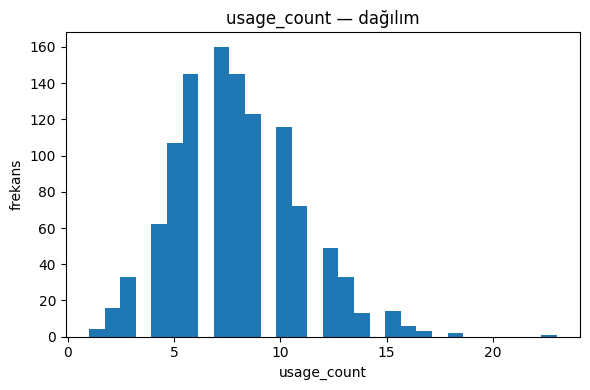

In [ ]:
# usage_count dağılımı
plt.figure()
plt.hist(df["usage_count"].dropna(), bins=30)
plt.title("usage_count — dağılım")
plt.xlabel("usage_count")
plt.ylabel("frekans")
plt.tight_layout()
plt.show()

---

#### **`session_minutes` Dağılımı: Tipik Bir Oturum Ne Kadar Sürer?**

**Bu Grafikten Ne Öğreniyoruz?**

*   **Grafiği Okumak:**
    * Yatay eksen, müşterinin bir oturumda geçirdiği süreyi dakika cinsinden gösterir. Dikey eksen ise o süre aralığında kaç adet oturum olduğunu belirtir

*   **Merkezi Eğilim:**
    * Dağılımın zirvesi (tepe noktası olarak da bilinir), yani en sık gözlemlenen oturum süreleri, 20 ila 30 dakika arasında yoğunlaşmıştır. Grafiğin tam merkezi yaklaşık 25 dakika civarındadır.
    * Bu bize "tipik" bir kullanıcı oturumunun yaklaşık 25 dakika sürdüğünü söyler.

*   **Dağılımın Şekli (Simetri):**
    * `usage_count`'taki sağa çarpık yapının aksine, `session_minutes` dağılımı oldukça **simetriktir**.
    * Bu şekil, istatistikteki en meşhur dağılım olan **Normal Dağılım'a (veya "Çan Eğrisi")** çok benzemektedir.
    * Verilerin bir ortalama değer etrafında dengeli bir şekilde yayıldığı anlamına gelir. Çok kısa (örn: 5 dakikadan az) ve çok uzun (örn: 45 dakikadan fazla) oturumlar, ortalamaya kıyasla giderek daha nadir görülür.

*   **Yayılım:**
    * Müşteri oturumlarının büyük çoğunluğu kabaca 10 ila 40 dakika arasında yer almaktadır. 50 dakikayı aşan oturumlar ise oldukça nadirdir.

**Bu Analiz Neden Önemli?**

1.  **Eksik Değer Doldurma Stratejisi:**
    * Dağılım simetrik olduğu için, bu sütundaki eksik değerleri doldururken **ortalama (mean)** veya **medyan (median)** kullanmak arasında büyük bir fark olmayacaktır.
    * Her ikisi de dağılımın merkezini (yaklaşık 25) doğru bir şekilde temsil edecektir ve her ikisi de bu durumda çok güçlü ve mantıklı birer stratejidir.

2.  **Model Uyumluluğu:**
    * Birçok makine öğrenmesi modeli (özellikle doğrusal modeller ve bazı istatistiksel testler), özelliklerin normal dağılıma sahip olduğu varsayımı altında daha iyi performans gösterir.
    * `session_minutes` özelliğinin doğal olarak bu yapıya sahip olması, onu modele doğrudan dahil etmeden önce logaritma gibi karmaşık dönüşümlere ihtiyaç duymayacağımız anlamına gelir.
    * Bu işimizi kolaylaştıran bir durumdur.

3.  **Beklentileri Doğrulama:**
    * Bu görsel, veri oluşturma aşamasında `rng.normal(loc=25, ...)` kodunu kullanarak yaptığımız varsayımın doğru bir şekilde veriye yansıdığını teyit etmiş olur.

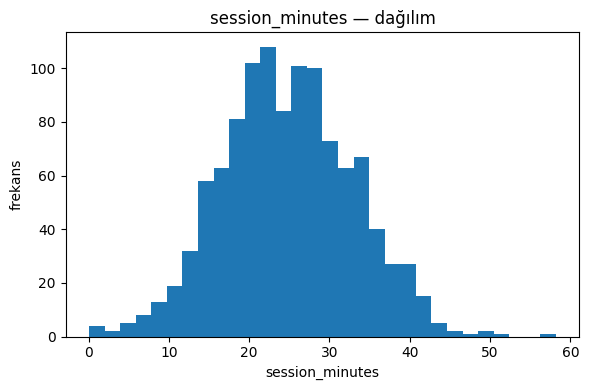

In [ ]:
# @title #### Kod
# session_minutes dağılımı
plt.figure()
plt.hist(df["session_minutes"].dropna(), bins=30)
plt.title("session_minutes — dağılım")
plt.xlabel("session_minutes")
plt.ylabel("frekans")
plt.tight_layout()
plt.show()

---
#### **`spend` Dağılımı: Müşteri Harcamalarının Yapısı**

Son olarak, müşterilerin ne kadar harcama yaptığını gösteren `spend` sütununu inceliyoruz. Bu dağılım, genellikle bir şirketin gelir yapısı hakkında önemli ipuçları içerir.

**Bu Grafikten Ne Öğreniyoruz?**

*   **Grafiği Okumak:**
    * Yatay eksen harcama miktarını, dikey eksen ise o miktarda harcama yapan müşteri sayısını gösterir.

*   **Merkezi Eğilim:**
    * Müşterilerin en yoğun olduğu bölge, 25-60 birimlik harcama aralığıdır. Müşteri tabanının büyük bir kısmının bu seviyede harcama yaptığını gösterir.

*   **Dağılımın Şekli (Çarpıklık):**
    * Bu dağılım `usage_count` özelliğinde olduğu gibi, güçlü bir şekilde **sağa çarpıktır (positively skewed)**.
    * Finansal verilerde (gelir, harcama, servet) çok sık rastlanan bir durumdur. Anlamı şudur: Müşterilerin büyük bir çoğunluğu görece daha düşük harcamalar yaparken, az sayıda "yüksek harcama yapan" müşteri 150, 200 veya daha fazla harcama yaparak dağılımın "kuyruğunu" sağa doğru uzatır.

*   **Yayılım:**
    * Harcamalar 0'a yakın değerlerden başlayıp neredeyse 300'e kadar uzansa da, verinin ezici çoğunluğu 100'ün altında toplanmıştır.

**Bu Analiz Neden Kritik?**

1.  **Eksik Değer Doldurma Stratejisi:**
    * Bu tür çarpık bir dağılımda, **ortalama (mean)** değeri, sağdaki aşırı yüksek değerler tarafından yukarı çekileceği için yanıltıcı olacaktır. Örneğin, 9 kişinin harcaması 50 TL, 1 kişinin harcaması 1050 TL ise ortalama 150 TL olur, ancak bu 10 kişiden 9'unu temsil etmez.
    * Bu nedenle, eksik `spend` değerlerini doldurmak için **medyan (median)** kullanmak çok daha **sağlam (robust)** ve doğru bir yaklaşımdır. Medyan bu aykırı yüksek değerlerden etkilenmez ve "tipik" müşterinin harcamasını daha iyi yansıtır.

2.  **Özellik Dönüşümü (Feature Transformation):**
    * Birçok makine öğrenmesi modeli, özelliklerin normal dağılıma yakın olmasını tercih eder. `spend` gibi güçlü bir şekilde çarpık olan özellikleri doğrudan modele vermek, performansı düşürebilir.
    * Bu durumu düzeltmek için yaygın bir teknik, özellik üzerinde **logaritmik dönüşüm** (`np.log1p` gibi) uygulamaktır. Bu dönüşüm, sağdaki uzun kuyruğu "içeri doğru çekerek" dağılımı daha simetrik hale getirir ve genellikle model performansını artırır.

3.  **İş Anlayışı (Business Insight):**
    * Bu grafik şirketin gelirinin muhtemelen Pareto prensibine benzer bir yapıda olduğunu ima eder: Gelirin büyük bir kısmı, müşteri tabanının küçük bir yüzdesinden geliyor olabilir.
    * Ppazarlama ve müşteri ilişkileri stratejileri için (örneğin, yüksek değerli müşterileri elde tutma programları) önemli bir bilgidir.

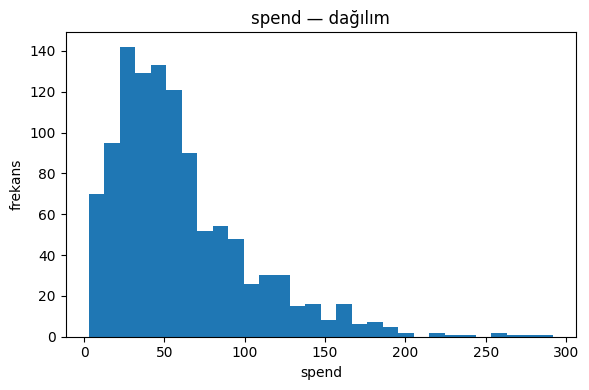

In [ ]:
# spend dağılımı
plt.figure()
plt.hist(df["spend"].dropna(), bins=30)
plt.title("spend — dağılım")
plt.xlabel("spend")
plt.ylabel("frekans")
plt.tight_layout()
plt.show()

---

#### Eksik Değerlerin Toplu Görünümü

Önceki adımlarda sayısal özelliklerin dağılımlarını tek tek inceledik. Şimdi ise bir adım geri çekilip tüm veri setindeki eksik değer tablosuna bütünsel olarak bakalım. Hangi sütunlarda ne kadar "boşluk" olduğunu görmek, veri temizleme stratejimizi planlamanın ilk adımlarından biri olabilir.

**Bu Grafikten Ne Öğreniyoruz?**

*   **Grafiği Okumak:** Yatay eksen veri setimizdeki tüm sütunları, dikey eksen ise o sütunda bulunan toplam eksik (`NaN` veya `None`) değer sayısını gösterir.
*   **Sorunlu Sütunlar Netleşti:** Grafik bize hangi sütunların "temiz" hangilerinin "kirli" olduğunu bir bakışta gösteriyor.
    *   **Sayısal Eksiklik:** `usage_count`, `session_minutes` ve `spend` sütunlarının her birinde yaklaşık 100 adet eksik değer bulunuyor. Veri oluşturma aşamasında kasıtlı olarak eklediğimiz %8'lik eksikliğe karşılık gelir.
    *   **Kategorik Eksiklik:** `city` sütununda yaklaşık 60 adet eksik değer var. Bu da yine planladığımız %5'lik eksikliktir.
*   **Temiz Sütunlar:** `device`, `last_active`, `feedback`, `days_since` ve hedef değişkenimiz `churn` sütunlarında hiç çubuk olmaması, bu sütunlarda hiç eksik değer bulunmadığı anlamına gelir. Bu iyi bir haber, çünkü bu sütunlar için bir temizleme işlemi yapmamıza gerek yok.

**Bu Analiz Neden Önemli?**

1.  **Aksiyon Planı Oluşturma:** Bu grafik veri ön işleme (preprocessing) aşaması için bize net bir **"yapılacaklar listesi"** sunar. Hangi sütunların müdahaleye (eksik değer doldurma) ihtiyaç duyduğunu ve hangilerini olduğu gibi bırakabileceğimizi açıkça görüyoruz.
2.  **Strateji Belirleme:** Artık görevimiz net:
    *   Üç sayısal sütun (`usage_count`, `session_minutes`, `spend`) için bir doldurma stratejisi belirlemeliyiz. Daha önceki histogram analizlerimiz, bu sütunlar için **medyan** veya **ortalama** kullanmanın mantıklı olacağını göstermişti.
    *   Kategorik `city` sütunu için ayrı bir stratejiye ihtiyacımız var. Sayısal doldurma yöntemleri burada işe yaramaz. Bunun yerine "Bilinmiyor" gibi yeni bir kategori oluşturmak veya en sık tekrar eden şehir (mod) ile doldurmak gibi seçenekleri değerlendireceğiz.

3.  **İlerleme Takibi:** Bu grafik veirnin temizlenmesi öncesinin bir "anlık görüntüsüdür". Eksik değerleri doldurma işlemlerini tamamladıktan sonra bu grafiği tekrar çizerek tüm çubukların sıfıra indiğini teyit edebilir ve böylece temizleme işleminin başarılı olduğunu doğrulayabiliriz.


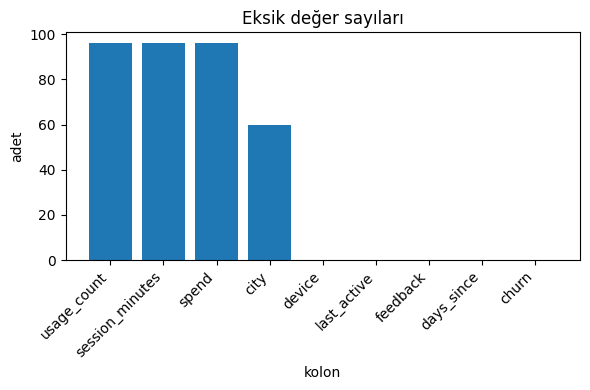

In [ ]:
miss = df.isna().sum().sort_values(ascending=False).to_frame("eksik_sayısı")
plt.figure()
plt.bar(miss.index.astype(str), miss["eksik_sayısı"].values)
plt.title("Eksik değer sayıları")
plt.xlabel("kolon")
plt.ylabel("adet")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

> **UNUTMA:** İmputasyon/ölçekleme gibi dönüşümler **eğitim seti** içinde öğrenilmeli; aksi halde **veri sızıntısı** oluşur.

## 3) Eksik Değer İmputasyonu (Sayısal/Kategorik)
Keşifsel veri analiziyle sorunları (eksik değerleri) tespit ettik, şimdi sıra bu sorunları çözmekte. Bu adıma **"imputasyon"** diyoruz, yani eksik verileri mantıklı tahminlerle doldurma sanatı. ML algoritmalarının çoğu, matematiksel doğaları gereği eksik (`NaN`) değerlerle çalışamaz.

Modeli eğitmeden önce bu boşlukları doldurmamız zorunludur. Ancak bu işlemi rastgele yapamayız; verinin yapısını bozmayacak, akıllı stratejiler kullanmalıyız.

Sklearn kütüphanesi bu iş için `SimpleImputer` ve `KNNImputer` gibi güçlü araçlar sunar.

### **Temel Stratejiler**

#### **Sayısal Sütunlar İçin:**

*  **Medyan (`median`):** Sütunun ortanca değerini kullanır.
    * Aykırı değerlerden (outlier) etkilenmediği için `spend` ve `usage_count` gibi çarpık dağılımlarda **güvenli ve sağlam (robust)** bir seçenektir.

*   **Ortalama (`mean`):** Sütunun aritmetik ortalamasını kullanır.
    * `session_minutes` gibi simetrik, normal dağılıma yakın sütunlar için uygundur, ancak aykırı değerlere karşı hassastır ve dağılımın merkezini kaydırabilir.

*   **K-En Yakın Komşu (`KNNImputer`):** Tek bir sütuna bakmak yerine **çok değişkenli (multivariate)** bir yaklaşım sunan daha gelişmiş bir yöntemdir.
    * Eksik değere sahip bir satırı doldurmak için, o satırın **diğer dolu sütunlarındaki değerleri** birer koordinat gibi kullanır.
    * Bu koordinatlara en yakın `k` adet komşu satırı bulur ve bu komşuların eksik sütundaki değerlerinin ortalamasını kullanarak bir tahminde bulunur.
    * **Basitçe, benzer satırların değerlerine bakarak bir tahmin yapar.**

*   **Kategorik Sütunlar İçin:**
    *   **En Sık (`most_frequent`):** Sütunda en çok tekrar eden kategoriyi (mod) kullanır. Genellikle iyi bir başlangıç noktasıdır.
    *   **Sabit Değer (`constant`):** `"Bilinmiyor"` gibi bizim belirleyeceğimiz sabit bir kategori ile doldurur. Bu eksikliğin kendisinin bir bilgi taşıdığı (örn: "kullanıcı bu alanı bilerek boş bıraktı") durumlarda çok faydalıdır.


### Sonuçların Analizi:

*   **Orijinal Eksik Değerler**
    *   Aşağıdaki tabloda `usage_count` sütununda `NaN` değerleri olan üç örnek satır görüyoruz.


        | usage_count | session_minutes | spend     |
        | :---------- | :-------------- | :-------- |
        | NaN         | 20.670611       | 52.451338 |
        | NaN         | 32.739524       | 30.686615 |
        | NaN         | 24.060417       | 79.383122 |

*   **Medyan ile Doldurma (`strategy="median"`)**
    *   `usage_count` sütununun medyanı `8.0`'dır.
    *   Bu strateji, **tüm eksik değerleri** aynı sabit değerle (`8.0`) doldurur. Basit, hızlı ve güvenilirdir.


        | usage_count | session_minutes | spend     |
        | :---------- | :-------------- | :-------- |
        | **8.0**     | 20.670611       | 52.451338 |
        | **8.0**     | 32.739524       | 30.686615 |
        | **8.0**     | 24.060417       | 79.383122 |


*   **Ortalama ile Doldurma (`strategy="mean"`)**
    *   `usage_count` sütununun ortalaması `7.918...`'dir.
    *   Medyan gibi, bu strateji de **tüm eksik değerleri** aynı sabit değerle doldurur.


        | usage_count | session_minutes | spend     |
        | :---------- | :-------------- | :-------- |
        | **7.918478**  | 20.670611       | 52.451338 |
        | **7.918478**  | 32.739524       | 30.686615 |
        | **7.918478**  | 24.060417       | 79.383122 |


*   **KNN ile Doldurma (`KNNImputer`)**
    *   Bu yöntem her satır için **farklı bir değer** üretebilir.
    *   Örneğin, ilk satırın `session_minutes` (20.6) ve `spend` (52.4) değerlerine sahip diğer 5 komşu satırını bulur ve onların `usage_count` ortalamasını (`6.2`) bu satıra atar.
    *   Üçüncü satırın komşuları farklı olduğu için, onun için farklı bir değer (`6.0`) hesaplar.


        | usage_count | session_minutes | spend     |
        | :---------- | :-------------- | :-------- |
        | **6.2**     | 20.670611       | 52.451338 |
        | **6.2**     | 32.739524       | 30.686615 |
        | **6.0**     | 24.060417       | 79.383122 |

### Önemli Bir Uyarı: Boyutsallık Laneti (Curse of Dimensionality) ve KNN

*   `KNNImputer`'ı "en akıllı" yöntem olarak etiketlemek doğru olmaz. Güçlü olduğu kadar ciddi bir zayıflığı da vardır: **Boyutsallık Laneti**.
*   KNN, "yakınlık" veya "benzerlik" kavramı üzerine kuruludur. Birkaç boyutta (sütunda) bu kavram anlamlıdır.
*   Ancak veri setindeki boyut (sütun) sayısı arttıkça, noktalar arasındaki Öklid mesafesi anlamsızlaşmaya başlar. Yüksek boyutlu bir uzayda, neredeyse tüm noktalar birbirinden eşit derecede "uzak" hale gelir.
*   Bu durum, `KNNImputer`'ın "en yakın komşu" olarak bulduğu satırların aslında hiç de yakın veya benzer olmamasına yol açar. Sonuç olarak, çok fazla (örneğin yüzlerce) sütun içeren bir veri setinde `KNNImputer`'ın tahminleri gürültülü ve güvenilmez hale gelebilir.

### Curse of Dimensionality Mantığı (Üyelere Özel Video)

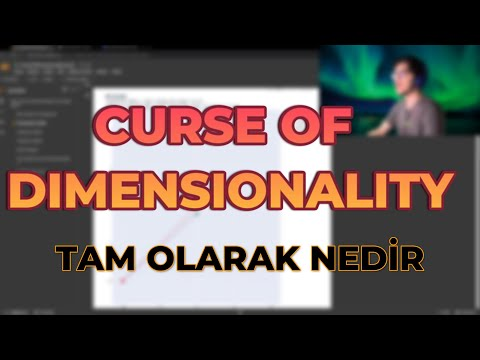

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo("EoHepRJomMM", width=800, height=600)

### Özet ve Seçim Kriterleri

*   **Hızlı ve Güvenli Başlangıç:** `SimpleImputer` ile `median` (sayısal için) ve `most_frequent` veya `constant` (kategorik için) kullanmak harika bir temel oluşturur.
*   **Daha Sofistike Yaklaşım:** `KNNImputer`, özellikler arasında anlamlı ilişkiler olduğunda ve boyut sayısı (sütun sayısı) makul seviyede olduğunda genellikle daha doğru tahminler yapar. Ancak hesaplama maliyeti daha yüksektir.
*   **Yüksek Boyutlu Veri:** Çok fazla özelliğiniz varsa, `KNNImputer`'dan kaçınmak ve `SimpleImputer` gibi daha basit yöntemleri veya `IterativeImputer` gibi daha gelişmiş model tabanlı yaklaşımları düşünmek daha iyi olabilir.

In [ ]:
num_cols = ["usage_count", "session_minutes", "spend"]
cat_cols = ["city", "device"]

num_imputer_median = SimpleImputer(strategy="median")
num_imputer_mean = SimpleImputer(strategy="mean")
num_imputer_knn = KNNImputer(n_neighbors=5)

cat_imputer = SimpleImputer(strategy="most_frequent")

# Örnek: yalnızca sayısal kolonlarda üç farklı imputasyon uygulayalım
df_num = df[num_cols]
m_med = pd.DataFrame(num_imputer_median.fit_transform(df_num), columns=num_cols)
m_mean = pd.DataFrame(num_imputer_mean.fit_transform(df_num), columns=num_cols)
m_knn = pd.DataFrame(num_imputer_knn.fit_transform(df_num), columns=num_cols)

nan_idxes = df[num_cols].isna().any(axis=1)

display(Markdown("**Eksik değerler**"))
display(df_num[nan_idxes].head(3).style.hide(axis="index"))
display(Markdown("**Eksik değerler (impute edilmiş - median)**"))
display(m_med[nan_idxes].head(3).style.hide(axis="index"))
display(Markdown("**Eksik değerler (impute edilmiş - knn)**"))
display(m_knn[nan_idxes].head(3).style.hide(axis="index"))
display(Markdown("**Eksik değerler (impute edilmiş - mean)**"))
display(m_mean[nan_idxes].head(3).style.hide(axis="index"))

**Eksik değerler**

usage_count,session_minutes,spend
nan,20.670611,52.451338
nan,32.739524,30.686615
nan,24.060417,79.383122


**Eksik değerler (impute edilmiş - median)**

usage_count,session_minutes,spend
8.000000,20.670611,52.451338
8.000000,32.739524,30.686615
8.000000,24.060417,79.383122


**Eksik değerler (impute edilmiş - knn)**

usage_count,session_minutes,spend
6.200000,20.670611,52.451338
6.200000,32.739524,30.686615
6.000000,24.060417,79.383122


**Eksik değerler (impute edilmiş - mean)**

usage_count,session_minutes,spend
7.918478,20.670611,52.451338
7.918478,32.739524,30.686615
7.918478,24.060417,79.383122


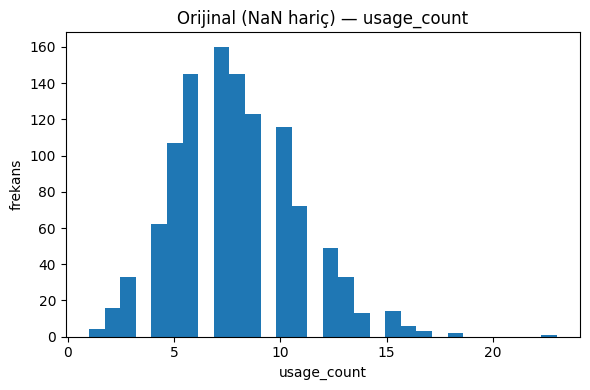

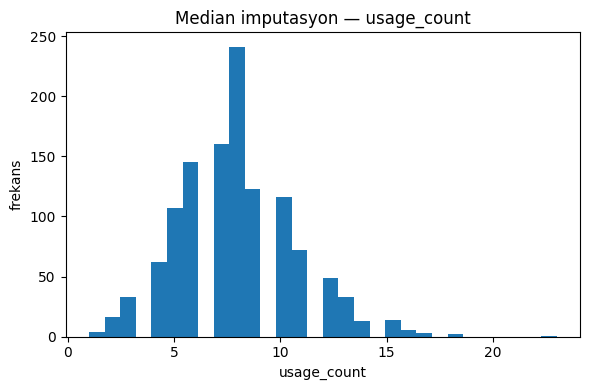

In [ ]:
# Tek değişken için etkileri görselleştirelim (usage_count)
plt.figure()
plt.hist(df["usage_count"].dropna(), bins=30)
plt.title("Orijinal (NaN hariç) — usage_count")
plt.xlabel("usage_count")
plt.ylabel("frekans")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(m_med["usage_count"], bins=30)
plt.title("Median imputasyon — usage_count")
plt.xlabel("usage_count")
plt.ylabel("frekans")
plt.tight_layout()
plt.show()

## 4) Aykırı Değerler: Tespit ve Sağlam Ölçekleme
Aykırı değerler modelinizi bozabilir. **IQR** ve **Z‑skor** popüler kurallardır.

$$  IQR = Q3 - Q1,\quad \text{alt sınır} = Q1 - 1.5\,IQR,\quad \text{üst sınır} = Q3 + 1.5\,IQR $$

$$ z = \frac{x - \mu}{\sigma} $$

Veri setinizdeki "aykırı değerler" (outliers), genel veri deseninden önemli ölçüde sapan gözlemlerdir. Bu değerler, veri giriş hatalarından, ölçüm arızalarından veya basitçe verinin doğal çeşitliliğinden kaynaklanabilir. Ancak nedenleri ne olursa olsun, aykırı değerler istatistiksel analizleri ve makine öğrenmesi modellerini ciddi şekilde yanıltabilir.

*   **Neden Sorun Yaratırlar?**
    *   **Ortalamayı Saptırırlar:** Tek bir aşırı değer bile, veri setinin ortalamasını (mean) kendi yönüne doğru çekerek yanıltıcı bir merkezi eğilim ölçüsü yaratır.
    *   **Varyansı Şişirirler:** Standart sapma ve varyans gibi yayılım ölçüleri, aykırı değerlere karşı aşırı hassastır.
    *   **Model Performansını Bozarlar:** Özellikle doğrusal modeller ve uzaklık tabanlı algoritmalar (KNN, K-Means gibi), aykırı değerlerin orantısız etkisine maruz kalarak verinin genel yapısını öğrenmekte zorlanır.

Bu bölümde, aykırı değerleri tespit etmek için kullanılan iki popüler kural tabanlı yöntemi ve onların etkisini azaltmak için kullanılan **sağlam (robust)** bir ölçekleme tekniğini inceleyeceğiz.

### Aykırı Değer Tespiti: İki Popüler Yöntem

#### IQR (Interquartile Range - Çeyrekler Arası Açıklık) Yöntemi

Bu yöntem, verinin dağılımına dair bir varsayımda bulunmadığı için (non-parametric) özellikle çarpık dağılımlar için çok güçlü ve güvenilirdir. Kutu grafiğinin (boxplot) arkasındaki mantık da budur.

*   **Nasıl Çalışır?**
    1.  **Q1 (1. Çeyreklik):** Veriyi küçükten büyüğe sıraladığımızda, verinin ilk %25'lik kısmının bittiği noktadaki değer bulunur.
    
    2.  **Q3 (3. Çeyreklik):** Benzer şekilde, verinin ilk %75'lik kısmının bittiği noktadaki değer bulunur.
    
    3.  **IQR Hesaplanır:** Bu iki değer arasındaki fark, verinin orta %50'sinin yayılımını gösterir.
        $$ IQR = Q3 - Q1 $$
    
    4.  **Sınırlar Belirlenir:** Verinin "normal" kabul edileceği bir alt ve üst sınır (bazen "çit" olarak adlandırılır) hesaplanır.
        $$ \text{Alt Sınır} = Q1 - 1.5 \times IQR $$
        $$ \text{Üst Sınır} = Q3 + 1.5 \times IQR $$
    
    5.  **Karar:** Bu sınırların dışında kalan herhangi bir veri noktası **aykırı değer** olarak etiketlenir.

*   **Avantajı:** Medyan ve çeyrekliklere dayandığı için, aykırı değerlerin kendisinden etkilenmez.

#### Z-Skoru (Z-Score) Yöntemi

Bu yöntem verinin yaklaşık olarak **Normal Dağılıma (Çan Eğrisi)** sahip olduğu varsayımına dayanır.

*   **Nasıl Çalışır?**
    1.  **Ortalama (μ) ve Standart Sapma (σ)** hesaplanır.
    2.  Her bir veri noktası (`x`) için Z-skoru hesaplanır. Z-skoru, bir noktanın ortalamadan kaç standart sapma uzakta olduğunu söyler.
       $$ \[ z = \frac{x - \mu}{\sigma} \] $$
    3.  **Eşik Belirlenir:** Genel bir kural olarak, mutlak değeri 3'ten büyük olan Z-skorlarına sahip noktalar (yani, ortalamadan 3 standart sapmadan daha uzağa düşenler) **aykırı değer** olarak kabul edilir.

*   **Dezavantajı:** Ortalama (`μ`) ve standart sapma (`σ`), aykırı değerlere karşı çok hassastır. Birkaç aşırı değer bu iki istatistiği de "şişirerek" aykırı değerlerin kendilerini gizlemesine neden olabilir. Bu nedenle çarpık veya aykırı değer içeren verilerde kullanmak pek mantıklı olmayabilir.

### `RobustScaler`

Aykırı değerleri tespit ettikten sonra onları silmek her zaman en iyi seçenek değildir çünkü bu bilgi kaybına neden olabilir. Daha iyi bir yaklaşım, onların model üzerindeki orantısız etkisini azaltmaktır. Standart ölçekleme yöntemleri (`StandardScaler` gibi) ortalama ve standart sapma kullandığı için aykırı değerlerden olumsuz etkilenir.

İşte bu noktada `RobustScaler` devreye girer.

*   **`RobustScaler` Nasıl Çalışır?**
    *   Veriyi merkezlemek için **ortalama yerine medyanı** kullanır. Medyan, aykırı değerlerden etkilenmez.
    *   Veriyi ölçeklemek için **standart sapma yerine IQR'ı (Çeyrekler Arası Açıklık)** kullanır. IQR da aykırı değerlerden etkilenmez.

*   **Neden "Sağlam"?**
    *   Çünkü ölçekleme işlemini, verinin büyük bir kısmını oluşturan merkezi %50'lik dilime dayandırır. Bu sayede, uçlarda yer alan birkaç aykırı değerin, verinin genelinin ölçeklenmesini bozmasına izin vermez.
    *   Sonuç olarak, aykırı değerler hala veri setinde mevcuttur, ancak ölçekleri küçültülerek model üzerindeki aşırı etkileri törpülenmiş olur. Bu, özellikle aykırı değerlerin bulunduğu veri setlerinde model performansını önemli ölçüde artırabilir.

> **ÖNEMLİ:** Burada ne kadar genel kurallar olsa da "en iyi yöntem budur" diye bir şey söylemek mümkün olmaz. Her zaman verinin doğasına ve problemin gereksinimlerine göre karar verilmelidir.

In [ ]:
def iqr_bounds(s: pd.Series, k: float = 1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    return (q1 - k * iqr, q3 + k * iqr)


low, high = iqr_bounds(df["spend"].dropna())
outliers = ((df["spend"] < low) | (df["spend"] > high)).sum()
display(
    pd.DataFrame(
        [
            ["alt_sınır", round(low, 2)],
            ["üst_sınır", round(high, 2)],
            ["aykırı_adedi", int(outliers)],
        ],
        columns=["ölçü", "değer"],
    ).style.hide(axis="index")
)

ölçü,değer
alt_sınır,-43.440000
üst_sınır,153.100000
aykırı_adedi,46.000000


#### Kodun ve Çıktının Yorumlanması

*   **`iqr_bounds` Fonksiyonu:**
    *   IQR kuralının adımlarını birebir uygular.

*   **Aykırı Değer Tespiti:**
    *   `((df["spend"] < low) | (df["spend"] > high))` kodu, `spend` sütunundaki her bir değer için bir kontrol yapar:
        * "Bu değer alt sınırdan küçük **veya** (`|`) üst sınırdan büyük mü?"
    *   Bu işlemin sonucu `True` (aykırı) ve `False` (normal) değerlerinden oluşan bir `boolean` `pd.Series`'dir.
    *   `.sum()` metodu bu Seriyi topladığında, `True` değerlerini 1, `False` değerlerini 0 olarak sayar ve bize toplam aykırı değer adedini verir.

*   **Çıktının Anlamı:**

        | ölçü         | değer    |
        | :----------- | :------- |
        | alt_sınır    | -43.44   |
        | üst_sınır    | 153.10   |
        | aykırı_adedi | 46.00    |


*   **Alt Sınır (-43.44):** Harcama (`spend`) gibi negatif olamayan bir özellik için negatif bir alt sınırın pratik bir anlamı yoktur. Bu bize verinin sola çarpık olmadığını, yani aşırı düşük anormal değerler olmadığını gösterir. Bu durumda sadece üst sınıra odaklanırız.
*   **Üst Sınır (153.10):** IQR kuralına göre, harcaması **153.10** birimden daha yüksek olan herhangi bir müşteri, istatistiksel olarak "aykırı" kabul edilir.
*   **Aykırı Adedi (46):** Veri setimizdeki **46** müşterinin harcaması bu üst sınırın üzerinde kalmıştır.

Bu 46 değeri silmeli miyiz?
  * **Hayır, hemen değil.** Bu müşteriler belki de bizim en değerli müşterilerimizdir. Bu tespit onları silmek yerine, modelimizi eğitirken onların orantısız etkisini azaltmak için `RobustScaler` gibi  yöntemlerini kullanmamız gerektiğini bize söyleyen bir işarettir.

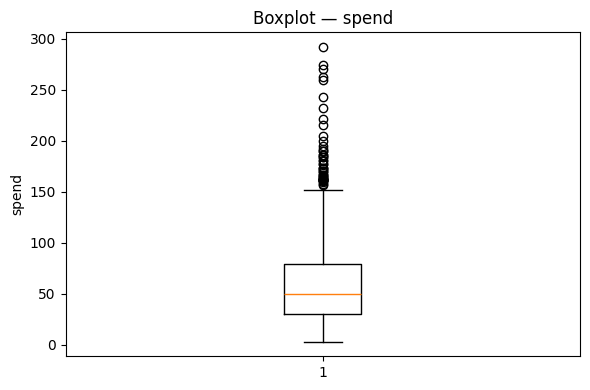

In [ ]:
# Boxplot ile spend (tek figür)
plt.figure()
plt.boxplot(df["spend"].dropna(), vert=True)
plt.title("Boxplot — spend")
plt.ylabel("spend")
plt.tight_layout()
plt.show()

Önceki adımda IQR yöntemini kullanarak programatik olarak aykırı değerleri tespit ettik. Kutu grafiği, bu tespitin **görsel bir özetidir** ve bize verinin dağılımı hakkında bir bakışta çok zengin bilgiler sunar.

### Bu Grafiği Nasıl Okumalıyız?

*   **Kutunun Kendisi (The Box):**
    *   Bu grafik verinin tam ortasındaki %50'lik kısmını, yani **Çeyrekler Arası Açıklığı (IQR)** temsil eder.
    *   Kutunun alt çizgisi:
      * **Q1** (1. çeyreklik, ~30 değeri),
      * Üst çizgisi ise **Q3** (3. çeyreklik, ~80 değeri) noktasıdır.
      
    Müşterilerin yarısı bu aralıkta harcama yapmıştır.

*   **Kutunun İçindeki Turuncu Çizgi:**
    *   Bu çizgi verinin **medyanını** (ortanca değer, ~50 değeri) gösterir. Müşterilerin tam yarısı bu değerden daha az, diğer yarısı ise daha fazla harcama yapmıştır.
    *   Bu çizginin kutunun alt kısmına daha yakın olması, histogramda gördüğümüz **sağa çarpık (positively skewed)** yapıyı teyit eder. Yani, veriler alt değerlerde daha yoğundur.

*   **Bıyıklar (Whiskers):**
    *   Kutudan uzanan dikey çizgiler, "normal" kabul edilen veri aralığını gösterir. Üst bıyık, bir önceki adımda hesapladığımız **üst sınıra (153.10)** çok yakın bir noktada biter. Bu çizginin ötesi, aykırı değerler bölgesidir.

*   **Daireler (Aykırı Değerler):**
    *   Üst bıyığın üzerinde yer alan her bir küçük daire, IQR kuralına göre **aykırı değer** olarak etiketlenmiş tek bir müşteri harcamasını temsil eder.
    *   Grafik bu aykırı değerlerin sayısının oldukça fazla olduğunu ve 300'e yakın değerlere kadar uzandığını net bir şekilde gösterir. Bu daireler bir önceki adımda saydığımız **46 adet aykırı değerin** görsel karşılığıdır.

Verinin büyük bir kısmı 150'nin altında yoğunlaşmışken, istatistiksel olarak anlamlı sayıda yüksek harcama yapan bir müşteri grubu bulunmaktadır.


**Sağlam ölçekleme:** Aykırılara dayanıklı **RobustScaler**, medyan ve IQR kullanır.

### Ölçekleme ve Dönüşüm

ML modellerinin çoğu (Decision Tree - Random Forest etkilenmez) özelliklerin farklı ölçeklerde olmasından olumsuz etkilenir. Örneğin, 0-1000 arasında değişen bir maaş özelliği ile 0-10 arasında değişen bir tecrübe yılı özelliği aynı anda modele verildiğinde, model büyük sayılara sahip maaş özelliğine orantısız bir şekilde daha fazla önem atfedebilir. Bu sorunu çözmek için **ölçekleme (scaling)** ve **dönüşüm (transformation)** teknikleri kullanılır.

Aşağıdaki grafikler, aykırı değerler içeren ve sağa çarpık olan `spend` sütunumuza farklı teknikler uygulandığında ne olduğunu göstermektedir.

#### Ölçekleyiciler (`Scaler`): Dağılımın Şekli Değişmez, Sadece Ölçeği Değişir

`StandardScaler`, `RobustScaler` ve `MinMaxScaler`, **doğrusal (linear)** dönüşümlerdir. Verinin orijinal dağılım şeklini (yani çarpıklığını) **değiştirmedikleri**, yalnızca eksen üzerindeki değerlerini (ölçeğini) değiştirdikleri anlamına gelir.

*   **`StandardScaler` ve `RobustScaler`**
    *   Bu iki grafiğe baktığımızda, görsel olarak neredeyse **aynı şekle** sahip olduklarını görürüz. Her ikisi de orijinal `spend` histogramındaki sağa çarpık yapıyı korur.
    *   **Temel Fark Nerede?**
        * Fark ölçeklemenin nasıl yapıldığındadır.
        * `StandardScaler`, aykırı değerlerden etkilenen **ortalama ve standart sapmayı** kullanır.
        * `RobustScaler` ise aykırı değerlerden etkilenmeyen **medyan ve IQR'ı** kullanır.
        * Bu nedenle, `spend` gibi aykırı değerler içeren bir veri seti için her ikisi de dağılımın şeklini düzeltmez. `X` eksenindeki değerler artık 0 etrafında merkezlenmiştir.

*   **`MinMaxScaler`**
    *   Bu ölçekleyici, tüm değerleri `0` ile `1` arasına sıkıştırır. Grafik, dağılımın şeklinin yine aynı kaldığını, ancak x ekseninin artık 0'dan 1'e gittiğini gösterir.
    *   **Dezavantajı:** Bu yöntemde, en küçük değer 0'a, en büyük değer (bir aykırı değer) ise 1'e haritalanır. Bu durum, verinin büyük bir kısmının (aykırı olmayan değerlerin) 0'a çok yakın dar bir aralığa sıkışmasına neden olurken, birkaç aykırı değer aralığın geri kalanını kaplar. Genellikle istenmeyen bir durumdur.

#### Logaritmik Dönüşüm (`log1p`): Dağılımın Şeklini Değiştirmek

Ölçekleyicilerin aksine, `log1p` (log(1+x)) **doğrusal olmayan (non-linear)** bir dönüşümdür. Amacı verinin ölçeğini değil, **doğrudan şeklini değiştirmektir.**

*   **`log1p` Grafiği**
    *   Bu grafikteki değişim çarpıcıdır. Diğer üç grafikteki bariz **sağa çarpıklık tamamen ortadan kalkmıştır.**
    *   Dağılım artık çok daha **simetrik** ve **Normal Dağılım'a (Çan Eğrisi)** benzer bir hal almıştır. Sağdaki uzun kuyruk, logaritma sayesinde "içeri doğru çekilmiştir".
    *   Birçok makine öğrenmesi modeli, özelliklerin normal dağılıma sahip olduğu varsayımı altında daha iyi çalıştığı için bu dönüşüm model performansı üzerinde genellikle olumlu bir etki oluşturabilir.
    * _Aman dikkat veri sola çarpıksa sizi hüsrana uğratabilir :)_


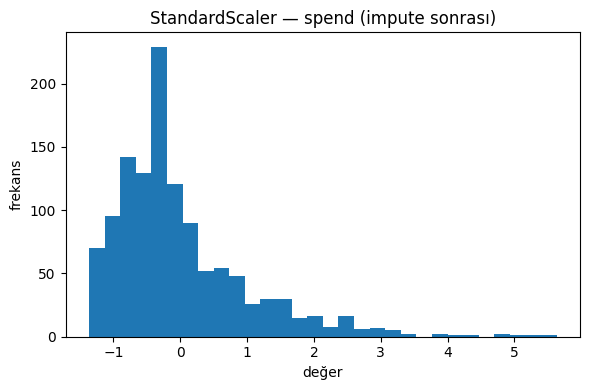

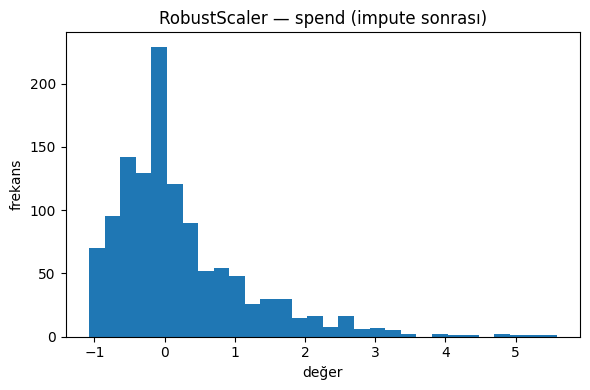

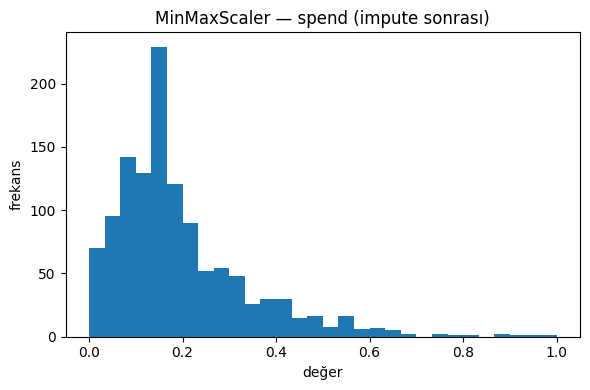

Text(0, 0.5, 'frekans')

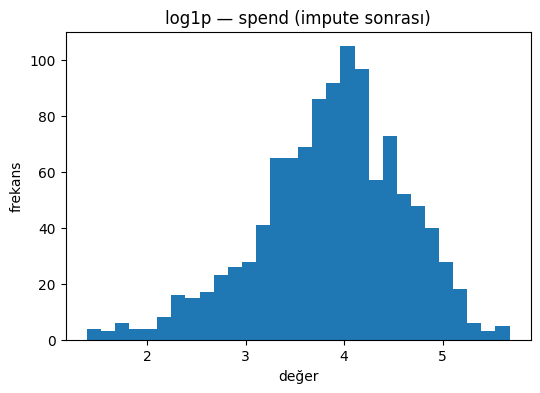

In [ ]:
sc_standard = StandardScaler()
sc_minmax = MinMaxScaler()
sc_robust = RobustScaler()

s = df[["spend"]].copy()
s_imputed = SimpleImputer(strategy="median").fit_transform(s)

std_vals = sc_standard.fit_transform(s_imputed).ravel()
mm_vals = sc_minmax.fit_transform(s_imputed).ravel()
rb_vals = sc_robust.fit_transform(s_imputed).ravel()

plt.figure()
plt.hist(std_vals, bins=30)
plt.title("StandardScaler — spend (impute sonrası)")
plt.xlabel("değer")
plt.ylabel("frekans")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(rb_vals, bins=30)
plt.title("RobustScaler — spend (impute sonrası)")
plt.xlabel("değer")
plt.ylabel("frekans")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(mm_vals, bins=30)
plt.title("MinMaxScaler — spend (impute sonrası)")
plt.xlabel("değer")
plt.ylabel("frekans")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(np.log1p(s), bins=30)
plt.title("log1p — spend (impute sonrası)")
plt.xlabel("değer")
plt.ylabel("frekans")

### Her Zaman Scale Etmeli Miyiz (Üyelere Özel Video)

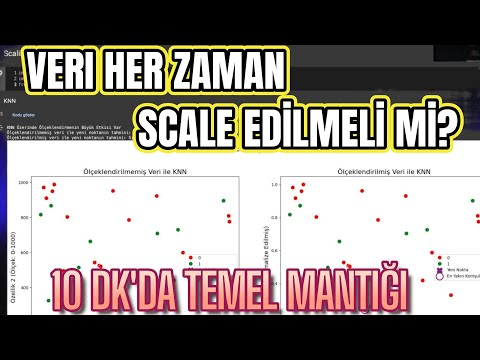

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo("sErIyJufSzY", width=1000, height=600)

## 5) Kategorik Kodlama (Encoding) - One-Hot - Ordinal ve Önemli Uyarılar

Makine öğrenmesi modelleri, temelinde matematiksel fonksiyonlardır ve bu nedenle metin etiketleriyle ("Ankara", "web" gibi) doğrudan çalışamazlar. Modeli eğitmeden önce bu kategorik verileri anlamlı sayılara dönüştürmemiz gerekir. Bu işleme **kategorik kodlama (categorical encoding)** denir.

Seçeceğimiz yöntem, kategorilerin doğasına bağlıdır: aralarında doğal bir sıralama var mı, yoksa yok mu?



### 1. One-Hot Encoding - Sırasız Kategoriler İçin

En yaygın kodlama yöntemlerinden birisidir. Kategoriler arasında doğal bir büyüklük-küçüklük ilişkisi **olmadığında** kullanılır.

*   **Ne Zaman Kullanılır?**
    *   `city` ("Ankara", "İstanbul", "İzmir")
    *   `device` ("web", "android", "ios")
    *   Bu örneklerde, "İstanbul" > "Ankara" gibi bir sıralama yapmak anlamsızdır. Bunlar **nominal (sırasız)** kategorilerdir.

*   **Nasıl Çalışır?**
    *   Orijinal kategorik sütunu kaldırır.
    *   Her bir benzersiz kategori için yeni bir ikili (binary) sütun oluşturur.
    *   Bir satır için, o satırın orijinal kategorisine karşılık gelen yeni sütuna `1`, diğer tüm yeni sütunlara ise `0` yazar.

*   **Örnek (`city` sütunu için):**


    | Orijinal |         | city_Ankara | city_İstanbul | city_İzmir |
    | :------- | :------ | :---------- | :------------ | :--------- |
    | Ankara   | **-->** | 1           | 0             | 0          |
    | İstanbul | **-->** | 0           | 1             | 0          |
    | İzmir    | **-->** | 0           | 0             | 1          |

*   **Dezavantajı (Uyarı):** Eğer bir sütunda çok fazla sayıda benzersiz kategori varsa (örn: 1000 farklı şehir), bu yöntem 1000 yeni sütun oluşturur. Bu durum, veri setinin boyutunu aşırı artırır ve **"boyutsallık lanetine" (curse of dimensionality)** yol açabilir (ayrıca sparsity dediğimiz, modellerin sevmediği input haline yaklaşırlar). Bu gibi durumlarda `OneHotEncoding` sınıfının oluşturacağı maks. sütun sayısını kısıtlamalıyız.

### Müko Not: Eğer bir ML pipeline’ında One-Hot Encoding için `pd.get_dummies` kullanıldığını görürseniz, oradan koşarak uzaklaşın. (Daha sonraki notebooklarda açıklandı.)

### Ordinal Encoding - Sıralı Kategoriler İçin

Bu yöntem, kategoriler arasında net ve anlamlı bir **sıralama veya hiyerarşi** olduğunda kullanılır.

*   **Ne Zaman Kullanılır?**
    *   Eğitim seviyesi: `["Lise", "Lisans", "Yüksek Lisans"]`
    *   Müşteri memnuniyeti: `["Kötü", "Orta", "İyi", "Çok İyi"]`
    *   Kıyafet bedeni: `["XS", "S", "M", "L", "XL"]`
    *   Bu örneklerde, "YL > Lisans" > "Lise" gibi bir sıralama yapmak anlamlıdır. Bunlar **ordinal (sıralı)** kategorilerdir.

*   **Nasıl Çalışır?**
    *   Her bir benzersiz kategoriyi, sıralamasını yansıtacak şekilde bir tam sayıya (`0, 1, 2, ...`) dönüştürür.

*   **Örnek (`memnuniyet` sütunu için):**

| Orijinal |         | memnuniyet_encoded |
| :------- | :------ | :----------------- |
| Kötü     | **-->** | 0                  |
| Orta     | **-->** | 1                  |
| İyi      | **-->** | 2                  |

*   **En Büyük Risk (Uyarı):** Bu yöntemi sırasız kategorilerde kullanmayın!


In [ ]:
example_cat = pd.DataFrame({"city": df["city"], "device": df["device"]})
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe_arr = ohe.fit_transform(example_cat)
ohe_df = pd.DataFrame(ohe_arr, columns=ohe.get_feature_names_out(["city", "device"]))
display(ohe_df.head().style.hide(axis="index"))

city_Ankara,city_Bursa,city_İstanbul,city_İzmir,city_None,device_android,device_ios,device_web
0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


## 6) Özellik Türetme: Tarih ve Metin (Temel)
Özellik türetme (Feature Engineering) ML'deki en yaratıcı ve genellikle en etkili adımlardan biridir.

Bu aşamada, mevcut ham verileri kullanarak modelin daha kolay öğrenebileceği, daha anlamlı ve yeni özellikler (sütunlar) yaratırız. Bu bir nevi veriye "domain bilgisi" (alan bilgisi) enjekte etmektir.

### Tarih Özellikleri - Verilen Bilgiyi Ayırıp Anlamlandırmak

Tek bir `last_active` tarih sütunu model için doğrudan çok anlamlı olmayabilir. Ancak bu tarihten birçok değerli sinyal türetebiliriz.

*   **Doğrudan Çıkarımlar:**
    *   `year`, `month`, `day`, `dow` (haftanın günü): Bu özellikler modelin zamana bağlı desenleri yakalamasını sağlar. Örneğin, satışlar belirli aylarda artıyor olabilir (mevsimsellik) veya kullanıcı aktivitesi haftanın belirli günlerinde (örn: Pazartesi) daha yoğun olabilir.
    *   `is_weekend`: "Hafta sonu mu?" gibi ikili bir bayrak oluşturmak, hafta içi ve hafta sonu davranışları arasındaki farkları modelin net bir şekilde öğrenmesine yardımcı olur.
    * Daha fazla özellikler türetilebilir, bayramlar, özel günler vb.

*   **Döngüsel Özellikler (Cyclical Features):**
    *   **Problem:** Ayları `1, 2, ..., 12` gibi sayılarla kodlamak tehlikeli olabilir. Model için 12 (Aralık) ile 1 (Ocak) arasındaki sayısal fark `11`'dir ve bu en büyük farktır. Halbuki gerçekte bu iki ay birbirine en yakın aylardır (sadece 1 ay fark). Model bu döngüsel ilişkiyi anlayamaz.
    *   **Çözüm: Sinüs ve Kosinüs Dönüşümü:** Bu sorunu çözmek için ayları bir çember üzerine yerleştiririz (Rotation Matrix - şansa transformerlarda kullanılan Positional Encoding de benzer mantık izler :)). Tıpkı bir saatin 12'den sonra tekrar 1'e gelmesi gibi. Bunu matematiksel olarak sinüs ve kosinüs fonksiyonları ile yaparız:
        *   `month_sin = np.sin(2 * np.pi * ay / 12)`
        *   `month_cos = np.cos(2 * np.pi * ay / 12)`
    *   Bu iki yeni özellik (`month_sin` ve `month_cos`), birlikte, her ayın yıl döngüsü üzerindeki tam konumunu belirtir.
    
    Aşağıdaki grafikte de görüldüğü gibi, bu dönüşüm sayesinde Aralık ve Ocak ayları artık uzayda birbirine çok yakın noktalara dönüşür ve model bu yakınlığı doğru bir şekilde öğrenebilir. Bu teknik, haftanın günleri veya günün saatleri gibi diğer tüm döngüsel veriler için de hayati öneme sahiptir.



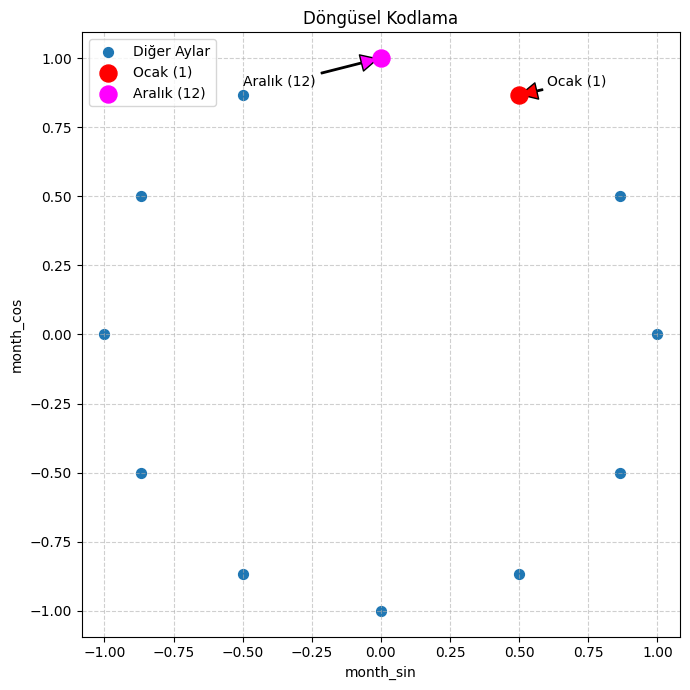

---

### Metin Özelliklerine Yüzeysel Bir Bakış

`feedback` gibi serbest metin alanları, Doğal Dil İşleme (NLP) ile derinlemesine analiz edilebilir. Ancak karmaşık modellere geçmeden önce, metinden çok basit ama etkili özellikler de türetebiliriz.

*   **Metrik Özellikler:**
    *   `len_chars` (karakter sayısı) ve `len_words` (kelime sayısı): Bir geri bildirimin uzunluğu, başlı başına bir sinyal olabilir. Çok kısa veya çok uzun yorumlar, genellikle güçlü (pozitif veya negatif) duyguları yansıtabilir. Genelde Google yorumlarında yazılan destan tarzı yorumlar, negatiftir. Burada domain de önemlidir.

*   **Basit Duygu Analizi:**
    *   `neg_hits` ve `pos_hits`: Önceden belirlenmiş pozitif ("harika", "memnun") ve negatif ("sorun", "yavaş") kelimelerden oluşan küçük sözlükler oluşturabiliriz.
    *   Ardından her bir geri bildirim metninde bu kelimelerin kaç kez geçtiğini sayarız. Metnin genel duygu tonu hakkında modele hızlı ve basit bir ipucu verir.


In [ ]:
def make_date_features(s: pd.Series) -> pd.DataFrame:
    out = pd.DataFrame(index=s.index)
    out["year"] = s.dt.year
    out["month"] = s.dt.month
    out["day"] = s.dt.day
    out["dow"] = s.dt.dayofweek  # 0=Pztsi
    out["is_weekend"] = out["dow"].isin([5, 6]).astype(int)

    # döngüsel
    out["month_sin"] = np.sin(2 * np.pi * out["month"] / 12)
    out["month_cos"] = np.cos(2 * np.pi * out["month"] / 12)
    return out


def make_text_basic(s: pd.Series) -> pd.DataFrame:
    out = pd.DataFrame(index=s.index)
    out["len_chars"] = s.fillna("").str.len()
    out["len_words"] = s.fillna("").str.split().str.len()
    neg = ["yavaş", "hata", "kötü", "pahalı", "sorun"]
    pos = ["harika", "memnun", "kolay", "tavsiye"]
    out["neg_hits"] = s.fillna("").apply(lambda x: sum(w in x for w in neg))
    out["pos_hits"] = s.fillna("").apply(lambda x: sum(w in x for w in pos))
    return out


date_feats = make_date_features(df["last_active"])
text_feats = make_text_basic(df["feedback"])

display(date_feats.head().style.hide(axis="index"))
display(text_feats.head().style.hide(axis="index"))

year,month,day,dow,is_weekend,month_sin,month_cos
2024,3,18,0,0,1.000000,0.000000
2024,2,11,6,1,0.866025,0.500000
2024,2,19,0,0,0.866025,0.500000
2024,4,14,6,1,0.866025,-0.500000
2024,2,22,3,0,0.866025,0.500000


len_chars,len_words,neg_hits,pos_hits
8,1,0,1
5,1,1,0
10,2,0,0
13,2,1,0
14,2,0,1


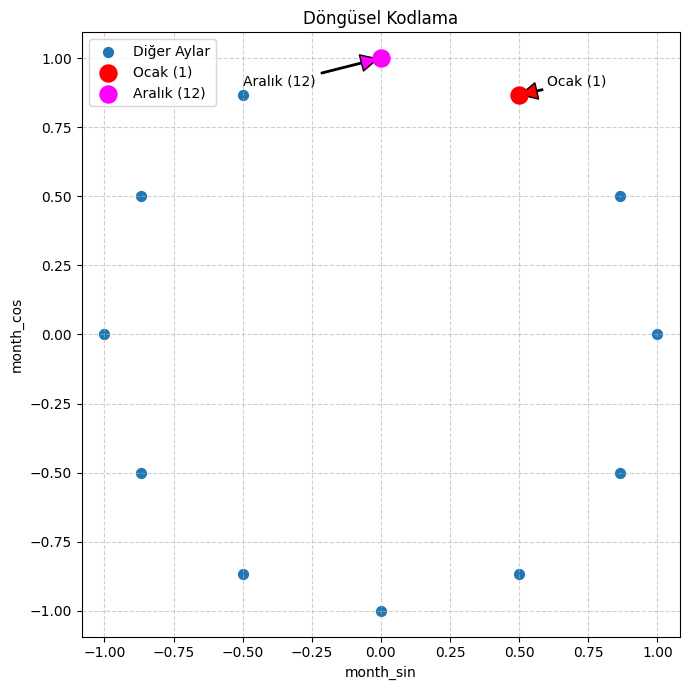

In [ ]:
months_df = pd.DataFrame({"month": range(1, 13)})

months_df["month_sin"] = np.sin(2 * np.pi * months_df["month"] / 12)
months_df["month_cos"] = np.cos(2 * np.pi * months_df["month"] / 12)

plt.figure(figsize=(7, 7))  # Kare - çünkü daire göstereceğiz

plt.scatter(months_df["month_sin"], months_df["month_cos"], s=50, label="Diğer Aylar")

jan_data = months_df[months_df["month"] == 1]
dec_data = months_df[months_df["month"] == 12]

plt.scatter(
    jan_data["month_sin"],
    jan_data["month_cos"],
    c="red",
    s=150,
    zorder=5,
    label="Ocak (1)",
)
plt.scatter(
    dec_data["month_sin"],
    dec_data["month_cos"],
    c="magenta",
    s=150,
    zorder=5,
    label="Aralık (12)",
)

plt.annotate(
    "Ocak (1)",
    xy=(jan_data["month_sin"].iloc[0], jan_data["month_cos"].iloc[0]),
    xytext=(0.6, 0.9),
    arrowprops=dict(facecolor="red", shrink=0.05, width=1),
)

plt.annotate(
    "Aralık (12)",
    xy=(dec_data["month_sin"].iloc[0], dec_data["month_cos"].iloc[0]),
    xytext=(-0.5, 0.9),
    arrowprops=dict(facecolor="magenta", shrink=0.05, width=1),
)

plt.title("Döngüsel Kodlama")
plt.xlabel("month_sin")
plt.ylabel("month_cos")
plt.axis("equal")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

## 7) Ayrıklaştırma (Binning) ve Etkileşimler

Bazen bir özelliğin ham sayısal değeri yerine, o değerin hangi aralığa düştüğü model için daha anlamlı olabilir. Ayrıca bazen iki özelliğin bir araya geldiğinde yarattığı etki, tek başlarına yarattıkları etkilerin toplamından daha fazladır.

### 1. Ayrıklaştırma (Binning): Sayısalları Kategorilere Ayırmak

Ayrıklaştırma, sürekli sayısal bir özelliği, sıralı kategorilere ("kutulara" veya "bin'lere") ayırma işlemidir. Modelin doğrusal olmayan ilişkileri daha kolay yakalamasına yardımcı olabilir veya çok fazla sütun varsa bunları azaltmada kullanılabilir. Örneğin, bir modelin `usage_count`'un 5'ten 6'ya çıkmasının etkisini öğrenmesi yerine, "düşük kullanım" (0-5 arası) ve "orta kullanım" (6-10 arası) gibi grupların genel etkisini öğrenmesi daha kolay olabilir.

`KBinsDiscretizer`, bu işlemi otomatikleştirmek için güçlü bir araçtır.

*   **`strategy="quantile"` Stratejisi:**
    *   Bu strateji ayrıklaştırma işlemini yaparken kutuların (bin'lerin) sayısal aralıklarının eşit olmasını **hedeflemez**.
    *   Bunun yerine, her bir kutuya **yaklaşık olarak eşit sayıda veri noktası (müşteri)** düşmesini hedefler.
    *   Örneğin, 4 kutu (bin) oluşturduğumuzda, tüm müşterilerin %25'i ilk kutuya, sonraki %25'i ikinci kutuya ve bu şekilde devam ederek yerleştirilir.


In [ ]:
pd.Series(binned_usage.ravel()).value_counts()

,count
2.0,364
3.0,309
1.0,305
0.0,222


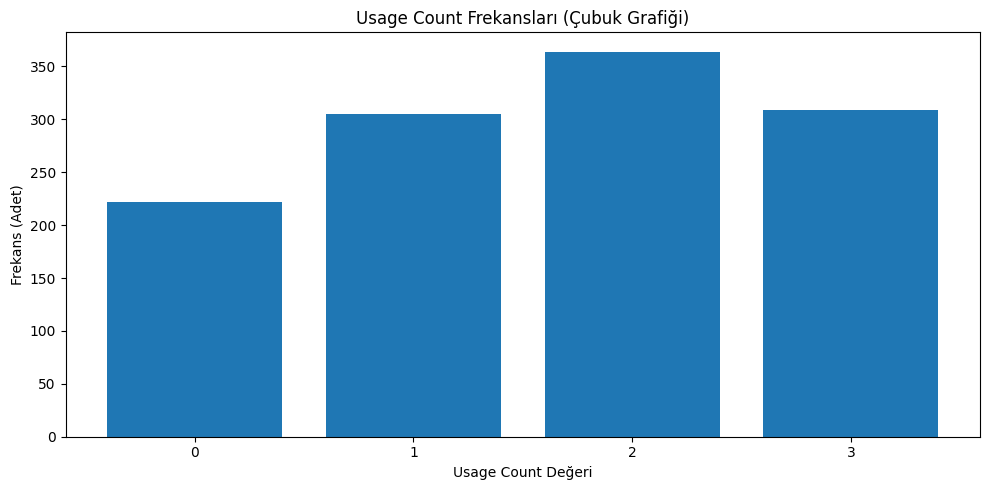

In [ ]:
binner = KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")
binned_usage = binner.fit_transform(
    df[["usage_count"]].fillna(df["usage_count"].median())
)
usage_counts = pd.Series(binned_usage.ravel()).value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(usage_counts.index, usage_counts.values)
plt.title("Usage Count Frekansları (Çubuk Grafiği)")
plt.xlabel("Usage Count Değeri")
plt.ylabel("Frekans (Adet)")
plt.xticks([0, 1, 2, 3])
plt.tight_layout()
plt.show()

*   Yukarıdaki histogram, `usage_count` özelliğinin 4 kuantil kutusuna ayrıldıktan sonraki halini göstermektedir.
*   X ekseni artık `usage_count`'un orijinal değerlerini değil, müşterinin atandığı kutu numarasını (`0, 1, 2, 3`) gösterir.
*   Grafikteki sütunların yüksekliklerinin (frekanslarının) KABACA **eşittir**. Eşitlik hedeflenir fakat sağlanma garantisi yoktur.
*   Orijinal `usage_count` histogramının sağa çarpık yapısının aksine, veriyi daha dengeli bir şekilde temsil eder.


### Etkileşim Özellikleri Uygulaması: `PolynomialFeatures`

Önceki bölümde, iki veya daha fazla özelliğin bir araya geldiğinde yarattığı sinerjinin (etkileşimin) model için değerli bir sinyal olabileceğinden bahsetmiştik. `PolynomialFeatures` aracı, bu etkileşimleri ve özelliklerin karesi gibi doğrusal olmayan terimleri bizim için otomatik olarak oluşturur.


#### Çıktının Yorumlanması: Sayılar Nereden Geliyor?

3 özellik nasıl oldu da 9 özelliğe dönüştü?

*   **Orijinal Değerler (1. Satır):**
    *   `usage_count` = 10.0
    *   `session_minutes` = 27.47
    *   `spend` = 40.76

*   **Türetilmiş Değerler (1. Satır):**

| Orijinal Özellikler | ... | Karesel Özellikler | Etkileşim Özellikleri | ... |
| :--- | :--- | :--- | :--- | :--- |
| **usage_count** | **session_minutes** | **spend** | **usage_count^2** | **usage_count * session_minutes** | **session_minutes * spend** |
| 10.0 | 27.47 | 40.76 | **100.0** (10 * 10) | **274.71** (10 * 27.47) | **1119.60** (27.47 * 40.76) |

*   **`usage_count^2` (100.0):** Orijinal `usage_count` değerinin karesidir (`10.0 * 10.0`). Bu yeni özellik, modelin "kullanım sayısı arttıkça etkinin doğrusal değil, katlanarak artması" gibi ilişkileri öğrenmesine olanak tanır.

*   **`usage_count session_minutes` (274.71):** `usage_count` ile `session_minutes`'ın çarpımıdır (`10.0 * 27.470804`). Bu, "hem çok sık gelen hem de uzun oturumlar yapan kullanıcılar" gibi özel bir segmenti temsil eden bir etkileşim özelliğidir.

*   Diğer tüm yeni sütunlar da aynı şekilde orijinal üç sütunun birbirleriyle veya kendileriyle çarpılmasıyla oluşturulur.

### Neden ve Ne Zaman Kullanılır?

*   **Gücü:** `PolynomialFeatures`, özellikle **doğrusal modellerin (Linear Regression, Logistic Regression gibi)** karmaşık ve doğrusal olmayan ilişkileri yakalamasına olanak tanır. Doğrusal bir model, `usage_count^2` terimini gördüğünde artık parabolik bir ilişkiyi bile modelleyebilir hale gelir.

*   **En Büyük Risk (Tekrar):** Bu yöntem, özellik sayısını **üslü olarak** artırır. 3 özellikten 9 özellik ürettik. Eğer 10 özelliğimiz olsaydı, `degree=2` ile 55 yeni etkileşim/karesel terim, yani toplamda 65 özellik elde ederdik. `degree=3` ile bu sayı yüzleri bulurdu.

Bu nedenle, genellikle tüm veri setine körü körüne uygulamak yerine, alan bilginize dayanarak anlamlı olabileceğini düşündüğünüz birkaç etkileşim özelliğini **manuel olarak** oluşturmak daha güvenli ve yorumlanabilir bir stratejidir.


In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
num_sample = df[["usage_count", "session_minutes", "spend"]].copy()
num_sample = pd.DataFrame(
    SimpleImputer(strategy="median").fit_transform(num_sample),
    columns=num_sample.columns,
)
X_poly = poly.fit_transform(num_sample)
display(
    pd.DataFrame(X_poly, columns=poly.get_feature_names_out(num_sample.columns))
    .head()
    .style.hide(axis="index")
)

usage_count,session_minutes,spend,usage_count^2,usage_count session_minutes,usage_count spend,session_minutes^2,session_minutes spend,spend^2
10.000000,27.470804,40.755936,100.000000,274.708045,407.559361,754.645098,1119.598353,1661.046331
10.000000,21.296887,48.106735,100.000000,212.968866,481.067349,453.557379,1024.523678,2314.257945
7.000000,22.385168,55.912085,49.000000,156.696176,391.384593,501.095748,1251.601412,3126.161221
8.000000,14.416504,95.753311,64.000000,115.332036,766.026490,207.835601,1380.428038,9168.696614
11.000000,38.289711,48.282770,121.000000,421.186818,531.110474,1466.101949,1848.733312,2331.225915


## 7.1 Data Processing Inequality ve Yeni Özellik Eklemek
Bu noktada aklınıza teorik bir soru takılmış olabilir:

* "Eğer mevcut verilerden yeni özellikler türetiyorsak, olmayan bir yerden yeni bir bilgi mi oluşturmuş oluyoruz?

Bir verinin işlenmesinin, içerdiği bilgiyi artıramayacağını söyleyen bir prensip mevcuttur. `(Data Processing Inequality - DPI)`

Bu konuyu daha net anlamak için birkaç maddeye ayıralım:

*   **Data Processing Inequality Ne Söyler?**
    
    *   Eğer bir $X$ değişkeniniz varsa ve ondan (ister deterministik ister gürültülü) yeni bir $Z$ değişkeni ($Z=f(X)$) türetirseniz, bu yeni $Z$ değişkeninin başka bir $Y$ değişkeni (örneğin, bizim hedef değişkenimiz `churn`) hakkında taşıdığı karşılıklı bilgi (mutual information), orijinal $X$'in taşıdığı bilgiden **daha fazla olamaz**.

    *   Matematiksel olarak: $I(Y;Z) \le I(Y;X)$.
    
    *   Basitçe: Veriyi işlemek, o veride zaten olmayan **yeni bir bilgi oluşturamaz.**

*   **`PolynomialFeatures` Ne Yapar?**
    
    *   Bu araç, orijinal $X$ verisinin **deterministik fonksiyonlarını** oluşturur: $x_1, x_2, x_1^2, x_1x_2, \dots$
    
    *   Bu "yeni özellikler", aslında aynı verinin farklı bir şekilde yeniden ifade edilmesidir. Yeni bilgi eklemezler; en iyi ihtimalle mevcut bilgiyi **yeniden düzenlerler**. Zaten burada varsayılan olarak orijinal 1. derece özellikleri de korur. Yani genişletilmiş özellik setine bakarak orijinal veriyi birebir geri elde edebilirsiniz. Ne bilgi kazancı ne de bilgi kaybı vardır.

*   **Peki Performans Neden Artar?**
    
    *   Ana fikir şudur:
        * DPI aslında **bilginin varlığından** bahseder, seçtiğimiz modelin o bilgiye **ne kadar kolay erişebildiğinden** değil.
    
    *   Basit bir doğrusal model, $Y \approx x_1x_2$ gibi bir etkileşim ilişkisini tek başına temsil edemez.
    
    *   Ancak `PolynomialFeatures` ile genişletilmiş yeni uzayda, $x_1x_2$ terimi artık tek bir koordinat haline gelir. Bu sayede, bu yeni uzayda çalışan **doğrusal bir model**, bu ilişkiyi artık kolayca temsil edebilir.
    
    *   Yani $Y$ hakkında daha fazla bilgi elde etmedik; sadece **basit bir modele, mevcut bilgiyi doğrusal olarak erişilebilir kılan** daha zengin bir temsil sunduk.

*   **Akılda Tutulması Gerekenler:**
    
    *   Eğer orijinal özellikleri çıkarıp sadece karesel terimleri tutarsanız (`x^2` gibi), o zaman gerçekten **bilgi kaybedebilirsiniz**:
        * Çünkü `x` ve `-x` aynı `x^2` değerine haritalanır ve $I(Y;f(X))$ düşebilir.
    
    *   Sonlu bir veri setinde, çok fazla polinom terimi eklemek aşırı öğrenmeye (overfitting) yol açar.
        * Regularizasyon bu durumu kontrol etmek için kullanılır.

**Özetle: PolyFeatures verideki toplam bilgiyi değil, seçtiğiniz modelin ifade gücünü (expressive power) artırır.**


## 8) Özellik Seçimi: Gürültüyü Azaltıp Sinyali Güçlendirmek

Özellik türetme adımlarıyla veri setimizi zenginleştirdik ve birçok yeni sütun ekledik. Şimdi ise tam tersini yapma zamanı: Model performansını artırmak, aşırı öğrenmeyi (overfitting) azaltmak ve modeli daha basit hale getirmek için en iyi özellikleri seçip, geri kalanları eleyeceğiz.

### Özellik Seçimi Yöntemleri

Özellik seçimi için birçok strateji vardır biz burada üç popüler yaklaşımı inceleyeceğiz:

1.  **Filtre Yöntemleri (Filter Methods):** Model eğitmeden, sadece özelliklerin istatistiksel özelliklerine bakarak seçim yaparlar. Hızlıdırlar.
    *   `VarianceThreshold`: Düşük varyanslı özellikleri eler.
    *   `SelectKBest`: Her bir özelliğin hedef değişkenle olan ilişkisini bir skorla ölçer ve en yüksek skora sahip "K" adet özelliği seçer.

2.  **Sarmalayıcı Yöntemler (Wrapper Methods):** Farklı özellik alt kümelerini kullanarak modeli tekrar tekrar eğitir ve en iyi performansı veren alt kümeyi seçerler. Yavaştırlar ama genellikle en iyi sonuçları verirler. (Bu kursun ilerleyen konularında ele alınacaktır).

3.  **Gömülü/Model Tabanlı Yöntemler (Embedded/Model-based Methods):** Modelin eğitim süreci sırasında hangi özelliklerin daha önemli olduğunu öğrenmesini sağlarlar. (Örn: Lasso Regresyonu, RandomForest).

### Adım Adım Özellik Eleme

Öncelikle, şimdiye kadar oluşturduğumuz tüm özellikleri (orijinal sayısal, one-hot kodlanmış kategorik, tarih ve metin özellikleri) tek bir `DataFrame`'de birleştiriyoruz.

```python
# tasslak tasarım: sayısal + mühendislik sonrası bazı özellikler
X_base = pd.concat([
    df[["usage_count","session_minutes","spend"]],
    pd.get_dummies(df[["city","device"]], dummy_na=True), # dummy_na=True eksik şehirler için de bir sütun oluşturur
    date_feats, text_feats
], axis=1)

y = df["churn"]

X_base_imputed = pd.DataFrame(SimpleImputer(strategy="median").fit_transform(X_base), columns=X_base.columns)
```

#### 8.1. Filtre Yöntemi: `VarianceThreshold`

Bu sınıf en basit özellik seçimi filtresidir.

*   **Nasıl Çalışır?** Bir özelliğin varyansı, o özelliğin değerlerinin ne kadar dağıldığını ölçer. Eğer bir özelliğin varyansı çok düşükse (veya sıfırsa), bu, o özelliğin tüm satırlar için neredeyse aynı değeri aldığı anlamına gelir. Herkes için aynı olan bir özellik, modelin kimin churn edip kimin etmeyeceğini ayırt etmesine yardımcı olamaz, yani **bilgi taşımaz**.
*   **Uygulama:** `threshold=0.0` kullanarak, tüm satırlarda tamamen aynı değere sahip olan (yani sıfır varyanslı) sütunları eliyoruz.

```python
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif

vt = VarianceThreshold(threshold=0.0)
X_vt = vt.fit_transform(X_base_imputed)
# Hangi sütunların tutulduğunu takip edelim
kept_cols_vt = X_base_imputed.columns[vt.get_support()]
```

#### 8.2. `SelectKBest` ile Filtreleme

Biraz daha sofistike bir filtre yöntemidir. Her bir özelliğin hedef değişkeni (`churn`) tahmin etmede ne kadar "bilgilendirici" olduğunu ölçer.

*   **`mutual_info_classif` (Karşılıklı Bilgi):**
    *   Bir özelliğin değerini bilmenin, hedef değişkenin değerindeki belirsizliği ne kadar azalttığını ölçen bir metriktir.
    *   Skor ne kadar yüksekse, o özellik `churn`'ü tahmin etmek için o kadar faydalıdır.

*   **Uygulama:** `SelectKBest`'e, `mutual_info_classif` skorlarına göre en iyi **15** (`k=15`) özelliği seçmesini söylüyoruz.

```python
k = min(15, X_vt.shape) # Özellik sayımız 15'ten azsa, hepsini tut
skb = SelectKBest(mutual_info_classif, k=k)
X_kbest = skb.fit_transform(X_base_imputed[kept_cols_vt], y)
# En iyi K adet sütunun adlarını alalım
kept_cols_kbest = kept_cols_vt[skb.get_support()]
```

#### Sonuç: En İyi Özelliklerimiz ve One-Hot Encoding'in Etkisi

`SelectKBest`'in `churn`'ü tahmin etmek için en bilgilendirici bulduğu ilk 5 özellik şunlardır:

| kolon       |
| :---------- |
| spend       |
| city_Ankara |
| city_nan    |
| device_ios  |
| device_web  |

*   **Yorum:** Bir müşterinin ne kadar **harcama yaptığı (`spend`)** `churn`'ü tahmin etmede en güçlü sinyallerden biri olabilir.

*   **One-Hot Encoding'in Etkisi ve Yorumlanması (ÇOK ÖNEMLİ):**
    
    *   Unutulmaması gereken en önemli nokta `SelectKBest`'in `pd.get_dummies` ile oluşturulan her bir sütunu (`city_Ankara`, `city_İstanbul`, `city_nan` vb.) **tamamen bağımsız birer özellik olarak** değerlendirmesidir.
    
    *   Yani  `'city'` özelliğinin bir bütün olarak ne kadar önemli olduğunu değil, **`'Ankaralı olmanın'`** veya **`'şehir bilgisinin eksik olmasının'`** tek başına ne kadar güçlü bir sinyal olduğunu ölçer.
    
    *   Çıktımızda `city_Ankara` ve `city_nan`'ın seçilmesi bu iki durumun `churn`'ü tahmin etmede diğer şehirlerden (örn: `city_İstanbul`) daha fazla bilgi taşıdığı anlamına gelir. Belki de Ankara'daki müşterilerin churn davranışı belirgin bir şekilde farklıdır veya şehir bilgisini vermeyen müşteriler özel bir risk grubudur.
    
Bu adımların sonunda veri setimizi modelimiz için daha küçük ve verimli bir özellik setine indirgemiş olduk.

In [ ]:
# Taslak tasarım: sayısal + mühendislik sonrası bazı özellikler
## ML PIPELINE OLMADIĞI IÇIN PD.GET_DUMMIES KULLANABILIRIZ.
## SADECE BU FONKSIYONUN VARLIĞINI GOSTERMEK ISTEDIM, ML PIPELINE'DA ASLA KULLANILMAMALIDIR.
X_base = pd.concat(
    [
        df[["usage_count", "session_minutes", "spend"]],
        pd.get_dummies(df[["city", "device"]], dummy_na=True),
        date_feats,
        text_feats,
    ],
    axis=1,
)

y = df["churn"]

# Basit imputasyon
X_base_imputed = pd.DataFrame(
    SimpleImputer(strategy="median").fit_transform(X_base), columns=X_base.columns
)

# 8.1 VarianceThreshold
vt = VarianceThreshold(threshold=0.0)
X_vt = vt.fit_transform(X_base_imputed)
kept_cols_vt = X_base_imputed.columns[vt.get_support()]

# 8.2 SelectKBest (MI)
k = min(15, X_vt.shape[1])
skb = SelectKBest(mutual_info_classif, k=k)
X_kbest = skb.fit_transform(X_base_imputed[kept_cols_vt], y)
kept_cols_kbest = kept_cols_vt[skb.get_support()]

display(Markdown("**Seçilen ilk sütunlar (KBest):**"))
display(pd.DataFrame({"kolon": kept_cols_kbest}).head().style.hide(axis="index"))

**Seçilen ilk sütunlar (KBest):**

kolon
spend
city_Ankara
city_nan
device_ios
device_web


## 9) Tekrarlanabilir Boru Hattı (İsmi Böyle Geçiyor): ColumnTransformer + Pipeline
Şimdiye kadar veri temizleme, özellik türetme ve özellik seçimi gibi adımları manuel olarak, adım adım yaptık. Ancak bu yaklaşımın iki büyük riski vardır:

1.  **Veri Sızıntısı (Data Leakage):** Eğer veri setini eğitim ve test olarak ayırmadan *önce* eksik değerleri ortalama ile doldurur veya veriyi ölçeklerseniz, test setindeki bilgiyi (cevapları) farkında olmadan eğitim sürecine "sızdırmış" olursunuz.

    * Bu ise modelinizin olduğundan çok daha iyi görünmesine neden olur ve gerçek dünya performansında büyük hayal kırıklığı yaratır.

2.  **Tekrarlanabilirlik ve Hata Riski:** Manuel adımlar karmaşık, takibi zor ve hataya açıktır. Yeni veri geldiğinde tüm süreci aynı sırayla, hatasız bir şekilde tekrarlamak neredeyse imkansızdır.

**Çözüm:** Tüm bu `preprocessing` adımlarını ve modelin kendisini tek bir büyük nesnede birleştiren Sklearn `Pipeline` ve `ColumnTransformer` araçlarını kullanmak.

### Pipeline Mimarisi (Boru Hattı Demeyi Bırakalım)

Pipeline objesi bir fabrikadaki montaj hattı gibi çalışır. Ham veri bir uçtan girer ve bir dizi istasyondan geçerek:

* Temizleme
* Dönüştürme
* Ölçekleme  gibi işlemlerden geçerek

modelin eğitileceği son formata ulaşır.

#### 1. Özel Dönüştürücüler (Transformerler) -  Kendi Kurallarımızı Yazabiliriz

Sklearn'de tarih ve metin özelliklerini türetmek için hazır araçlar yoktur. Bu nedenle daha önce yazdığımız `make_date_features` ve `make_text_basic` fonksiyonlarının mantığını, `Pipeline` ile uyumlu hale getirmek için özel `transformer` sınıfları (`DateFeatureExtractor`, `TextLengthExtractor`) içinde yapmamız gerekir. Bu sınıflar Sklearn ekosisteminin bir parçası gibi davranmalarını sağlar.

```python
# Inheritance yapıyoruz - Subclassing
class DateFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        s = pd.to_datetime(X[self.col])
        out = pd.DataFrame(index=s.index)
        out["year"] = s.dt.year
        out["month"] = s.dt.month
        out["dow"] = s.dt.dayofweek
        out["is_weekend"] = out["dow"].isin([5,6]).astype(int)
        out["month_sin"] = np.sin(2*np.pi*out["month"]/12)
        out["month_cos"] = np.cos(2*np.pi*out["month"]/12)
        return out.to_numpy()

class TextLengthExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        s = X[self.col].fillna("")
        out = pd.DataFrame(index=s.index)
        out["len_chars"] = s.str.len()
        out["len_words"] = s.str.split().str.len()
        neg = ["yavaş","hata","kötü","pahalı","sorun"]
        pos = ["harika","memnun","kolay","tavsiye"]
        out["neg_hits"] = s.apply(lambda x: sum(w in x for w in neg))
        out["pos_hits"] = s.apply(lambda x: sum(w in x for w in pos))
        return out.to_numpy()
```

#### 2. Mini Pipeline Objeleri - Her Veri Tipi İçin Ayrı Bir Adım

Farklı veri türleri farklı işlemler gerektirir. Bu yüzden her biri için ayrı, küçük bir pipeline oluştururuz:

*   **`numeric_pipe`:** Sayısal sütunlar için reçete: "Önce medyan ile eksikleri doldur, sonra `RobustScaler` ile ölçekle."
*   **`categorical_pipe`:** Kategorik sütunlar için reçete: "Önce en sık tekrar edenle eksikleri doldur, sonra `OneHotEncoder` ile kodla."
*   **`date_pipe` ve `text_pipe`:** Kendi özel dönüştürücülerimizi kullanarak özellikleri türetirler.

```python
numeric_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

date_pipe = Pipeline([
    ("extract", DateFeatureExtractor("last_active")),
    ("imp", SimpleImputer(strategy="median"))
])

text_pipe = Pipeline([
    ("extract", TextLengthExtractor("feedback")),
    ("imp", SimpleImputer(strategy="median"))
])
```

#### 3. `ColumnTransformer` - Organizator

`ColumnTransformer` bu mini pipelineları yönetir.

**Görevi:** Ham veri setini alır ve hangi sütunların hangi pipeline'a gönderileceğini belirler.

    * "Siz sayısal sütunlar `numeric_pipe`'a gidin" veya
    * "Siz kategorik sütunlar `categorical_pipe`'a gidin"
    
gibi komutlar verir.

* Tüm bu paralel işlemleri yürüttükten sonra sonuçları birleştirerek modelin beklediği tek bir sayısal girdi oluşturur.

#### 4. Ana Pipeline (`clf`)

Son olarak tüm bu adımları tek bir büyük `Pipeline` içinde birleştiririz:

1.  **`prep` (Preprocessing):** Ham veriyi al ve yukarıda tanımlanan `ColumnTransformer` ile tamamen temizle ve dönüştür.
2.  **`poly` (Polynomial Features):** Temizlenmiş veriyi al ve 2. derece etkileşim özelliklerini oluştur.
3.  **`model` (Logistic Regression):** Son halini almış veriyi al ve Lojistik Regresyon modelini eğit.

### Veri Sızıntısı (Data Leak) Olmadan Model Kurmak

En kritik nokta burasıdır. `cross_val_score` fonksiyonuna bu bütünleşik `clf` pipeline verdiğimizde, Scikit-learn sihrini gösterir:

* Veriyi 5 parçaya (fold) ayırır.
* Her bir döngüde, 4 parçayı eğitim, 1 parçayı test olarak kullanır.
* **En Önemlisi:** Tüm pipeline (`clf`), her döngüde **sadece o anki 4 parçalık eğitim verisi üzerinde** `fit` edilir. Yani, eksik değerler için medyan hesaplaması, ölçekleme için IQR değerleri gibi tüm parametreler, test setini **hiç görmeden** öğrenilir.
*   Ardından bu eğitilmiş pipeline daha önce hiç görmediği test parçası üzerinde tahmin yapmak için kullanılır.

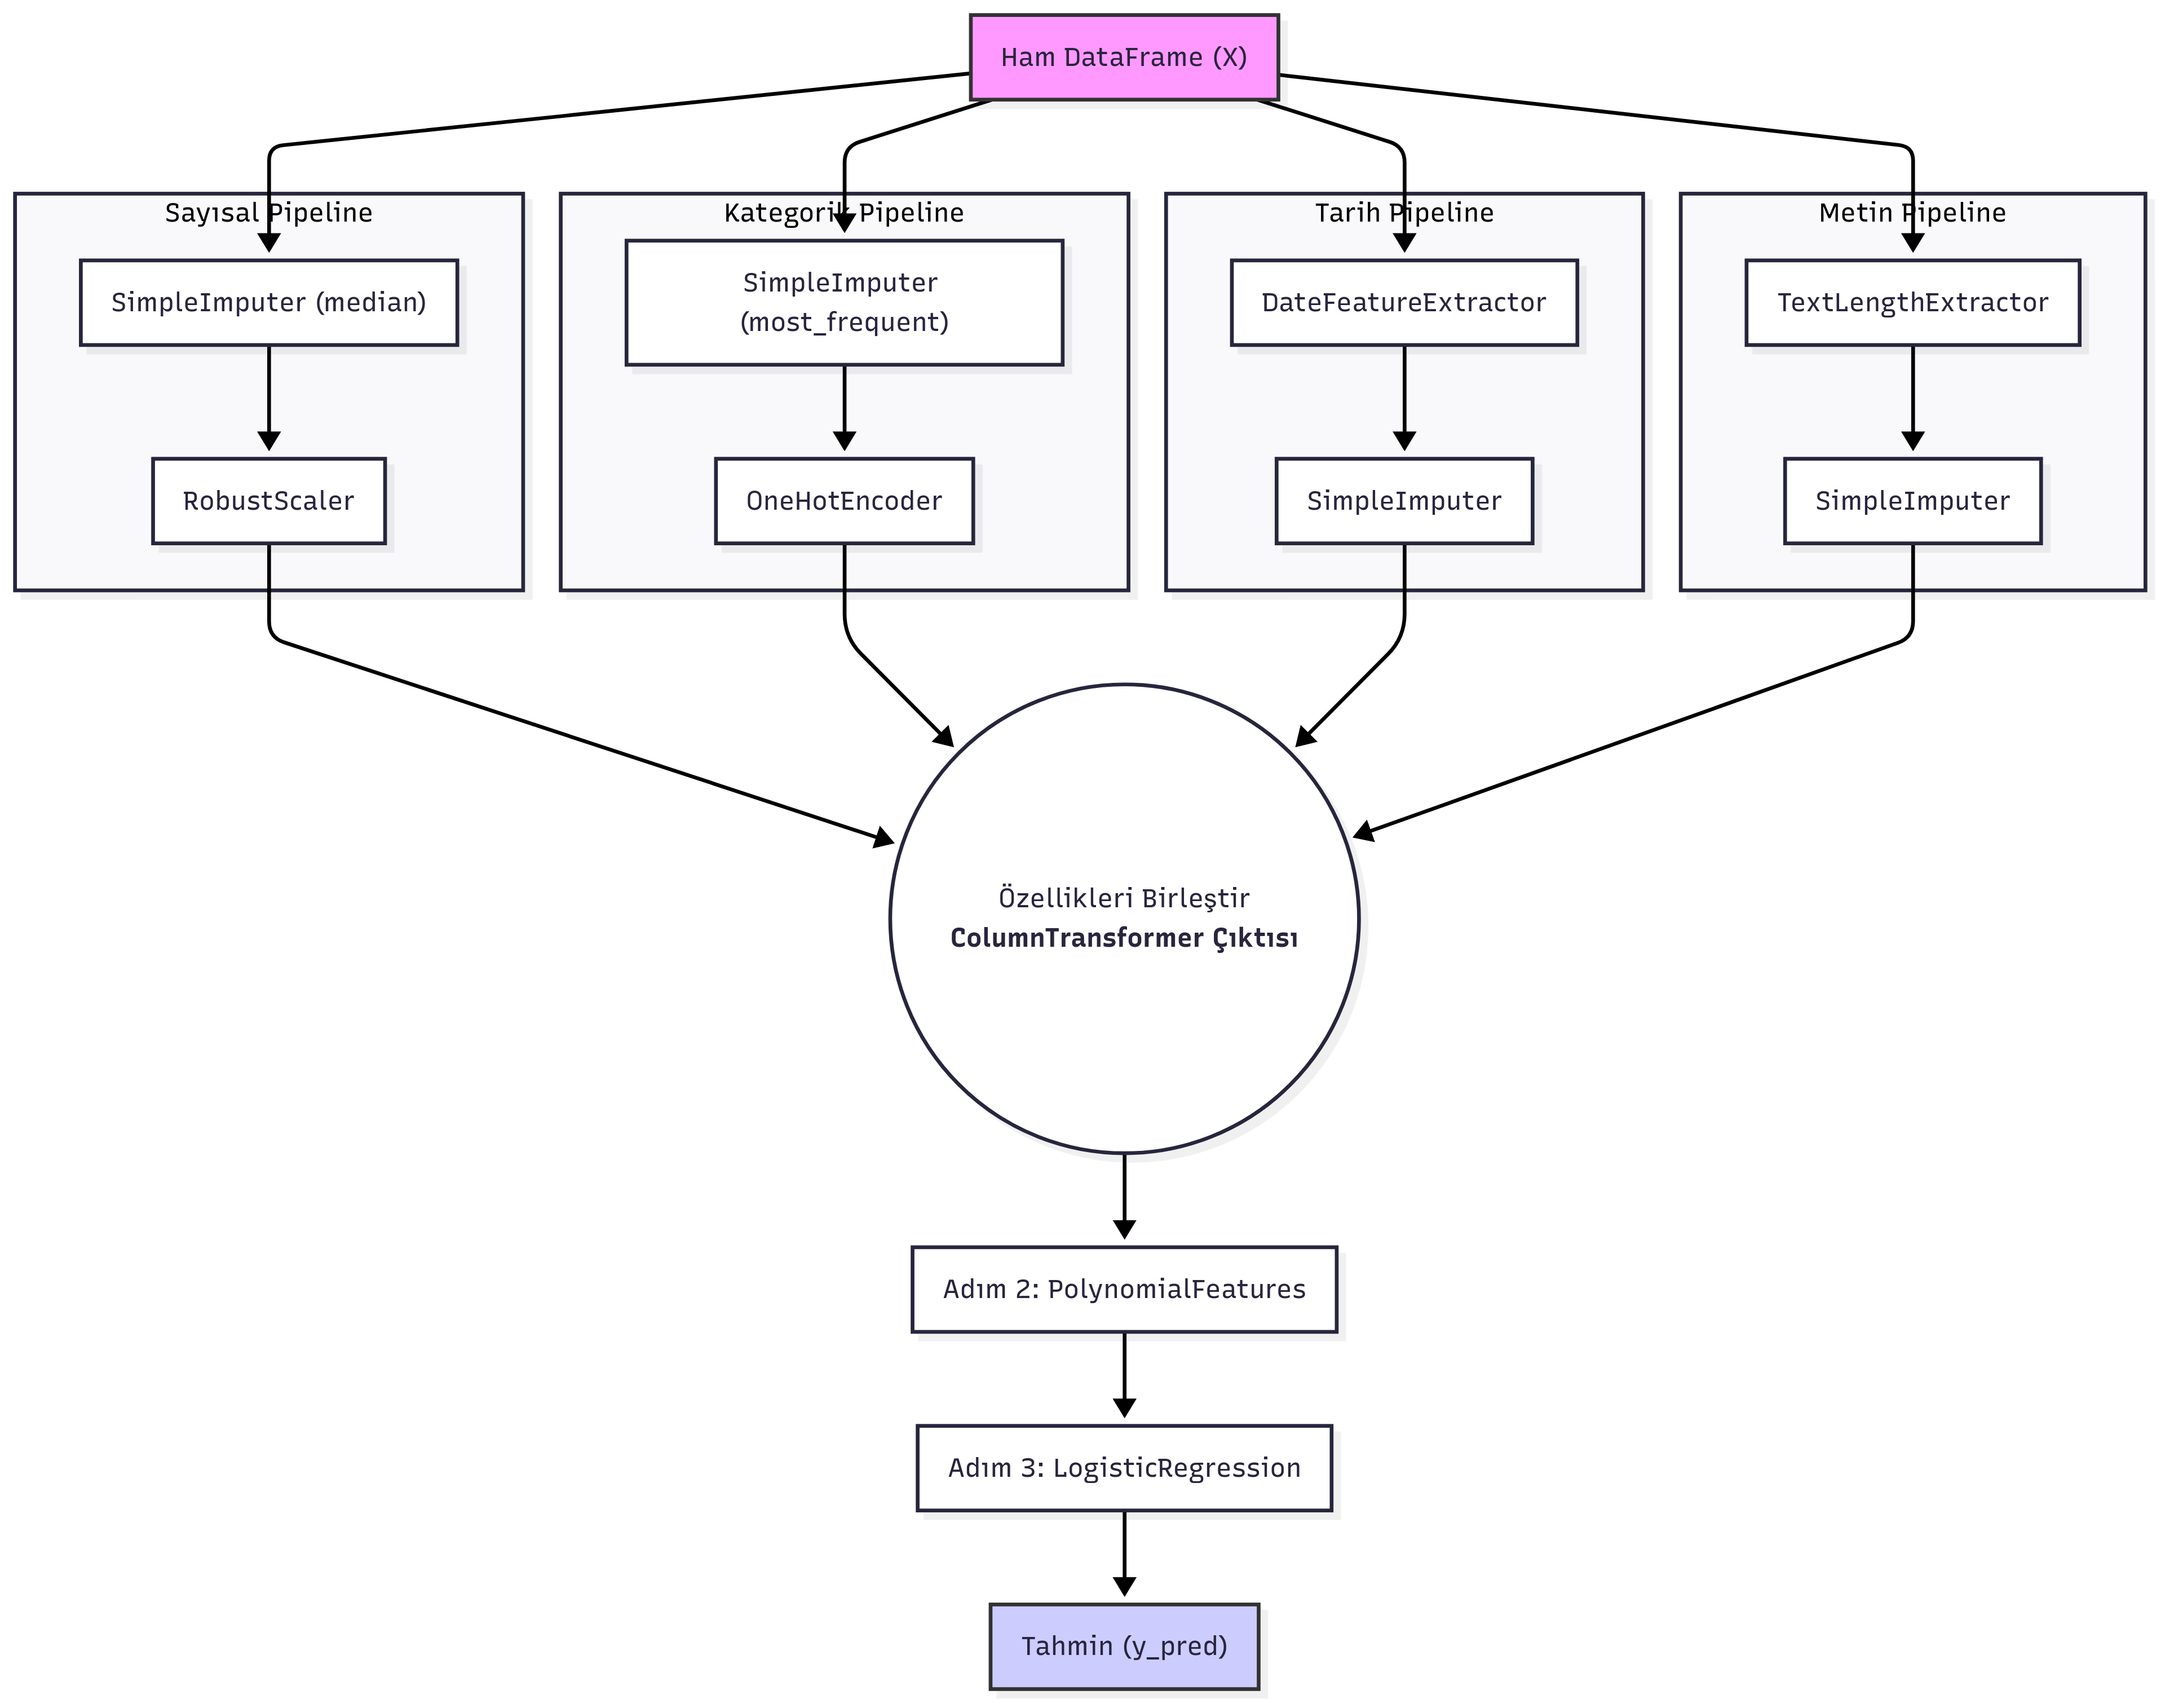

### Sonuçların Yorumlanması

|       | count | mean  | std   | min   | 25%   | 50%   | 75%   | max   |
| :---- | :---- | :---- | :---- | :---- | :---- | :---- | :---- | :---- |
| **F1**| 5.0   | 0.638 | 0.029 | 0.588 | 0.640 | 0.642 | 0.658 | 0.661 |

*   **`mean: 0.638`:** Modelimizin F1 skoru, 5 (`count`) farklı veri dilimi üzerinde ortalama olarak yaklaşık %63.8'dir. Bu, bizim temel performans ölçütümüzdür.

*   **`std: 0.029`:** Standart sapmanın düşük olması çok iyi bir işarettir. Bu bize modelimizin performansının, verinin farklı alt kümelerinde **tutarlı** olduğunu ve şansa bağlı olarak büyük dalgalanmalar göstermediğini belirtir. Modelimiz **sağlam (robust)** bir performans sergilemektedir.

In [ ]:
# Özel dönüştürücüler — tarih ve metin için
class DateFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        s = pd.to_datetime(X[self.col])
        out = pd.DataFrame(index=s.index)
        out["year"] = s.dt.year
        out["month"] = s.dt.month
        out["dow"] = s.dt.dayofweek
        out["is_weekend"] = out["dow"].isin([5, 6]).astype(int)
        out["month_sin"] = np.sin(2 * np.pi * out["month"] / 12)
        out["month_cos"] = np.cos(2 * np.pi * out["month"] / 12)
        return out.to_numpy()


class TextLengthExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        s = X[self.col].fillna("")
        out = pd.DataFrame(index=s.index)
        out["len_chars"] = s.str.len()
        out["len_words"] = s.str.split().str.len()
        neg = ["yavaş", "hata", "kötü", "pahalı", "sorun"]
        pos = ["harika", "memnun", "kolay", "tavsiye"]
        out["neg_hits"] = s.apply(lambda x: sum(w in x for w in neg))
        out["pos_hits"] = s.apply(lambda x: sum(w in x for w in pos))
        return out.to_numpy()


num_features = ["usage_count", "session_minutes", "spend"]
cat_features = ["city", "device"]

numeric_pipe = Pipeline(
    [("imp", SimpleImputer(strategy="median")), ("scaler", RobustScaler())]
)

categorical_pipe = Pipeline(
    [
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)

date_pipe = Pipeline(
    [
        ("extract", DateFeatureExtractor("last_active")),
        ("imp", SimpleImputer(strategy="median")),
    ]
)

text_pipe = Pipeline(
    [
        ("extract", TextLengthExtractor("feedback")),
        ("imp", SimpleImputer(strategy="median")),
    ]
)

preprocess = ColumnTransformer(
    [
        ("num", numeric_pipe, num_features),
        ("cat", categorical_pipe, cat_features),
        ("date", date_pipe, ["last_active"]),
        ("text", text_pipe, ["feedback"]),
    ]
)

clf = Pipeline(
    [
        ("prep", preprocess),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        (
            "model",
            LogisticRegression(max_iter=2000, n_jobs=None, random_state=RANDOM_STATE),
        ),
    ]
)

X = df.drop(columns=["churn", "days_since"])
y = df["churn"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores = cross_val_score(clf, X, y, cv=cv, scoring="f1")
display(pd.DataFrame({"F1": scores}).describe().T.round(3).style.hide(axis="index"))

count,mean,std,min,25%,50%,75%,max
5.000000,0.638000,0.029000,0.588000,0.640000,0.642000,0.658000,0.661000


## 10) Artefaktlar - Modeli Kaydetme/Yükleme

Bir ML modelini eğitmek saatler hatta günler sürebilen, yoğun hesaplama gerektiren bir süreçtir. Her yeni tahmin yapmak istediğimizde bu süreci en baştan tekrarlamak kesinlikle verimsizdir.

Çözüm, tüm eğitim sürecinin sonucunda ortaya çıkan "eğitilmiş zekayı" bir dosyaya kaydetmektir. Bu kaydedilmiş dosyalara makine öğrenmesi dünyasında **artefakt (artifact)** denir.

### Ne Kaydediyoruz? Sadece Model Değil - Tüm Pipeline'ı Kaydetmek

Bu sürecin en önemli ve en güçlü noktası şudur:
 * Biz sadece eğitilmiş `LogisticRegression` modelini değil, **`clf` adını verdiğimiz bütün `Pipeline` nesnesini** kaydediyoruz.

Bu `clf` nesnesi içinde şunları barındırır:
*   Tüm `ColumnTransformer` yapısı
*   Eksik değerleri doldurmak için eğitim verisinden öğrendiği **medyan** ve **en sık tekrar eden** değerler.
*   Veriyi ölçeklemek için öğrendiği **IQR** ve **medyan** istatistikleri (`RobustScaler`).
*   Kategorik veriyi kodlamak için öğrendiği tüm benzersiz kategoriler (`OneHotEncoder`).
*   Kendi yazdığımız özel tarih ve metin dönüştürücülerimiz.
*   Etkileşim özellikleri oluşturan `PolynomialFeatures` adımı.
*   Ve son olarak tüm bu işlenmiş verilerle eğitilmiş `LogisticRegression` modelinin öğrendiği **katsayılar (ağırlıklar)**.

Kısacası ham veriyi alıp bir tahmine dönüştürmek için gereken **tüm bilgi ve mantığı** tek bir dosyada saklamış oluyoruz.

In [ ]:
out_model = pathlib.Path("pipeline_churn.joblib")
joblib.dump(clf, out_model)
print("Kaydedildi →", out_model.resolve())

loaded = joblib.load(out_model)
sample = X_test.iloc[:1]
print("Örnek tahmin:", int(loaded.predict(sample)[0]))

Kaydedildi → /content/pipeline_churn.joblib
Örnek tahmin: 0
